In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import Logit
from scipy.stats.mstats import winsorize
import re

## PE

### Part 1: Assess the gross asset value of PE funds by vintage
The ADV data provides a view on capital invested by fund vintage year. As with your assignment, load the fund data from the ADV filings “formADV_7B1_15Q3_23Q4.csv”. Exclude feeder fund, fund of funds, and only keep fund type that are PE funds or venture capital funds.

In [3]:
def load_adv_7b1():
    # Load the dataset and specify date parsing
    adv = pd.read_csv("./formADV_7B1_15Q3_23Q4.csv", parse_dates=['end_date'])
    
    pe_funds = (adv
                .query("feederfund == 'N' & fundoffunds == 'N' & ((fundtype == 'Private Equity Fund') | (fundtype == 'Venture Capital Fund'))")
                # .query("grossassetvalue_m >= 5")
                # .assign(
                #     grossassetvalue_m=lambda x: winsorize(x['grossassetvalue_m'], limits=(0.01, 0.99)),
                #     minimuminvestment=lambda x: x['minimuminvestment'] / 1000000
                # )
            )
    
    return pe_funds

#### a) [2 points]Report how many unique fund id’s are in the data

In [4]:
pe_funds = load_adv_7b1()
pe_funds

,filingid,fundname,fundid,referenceid,feederfund,fundoffunds,fundtype,minimuminvestment,owners,end_date,grossassetvalue_m
23,965871,"SEIDLER EQUITY PARTNERS, L.P.",805-1847174657,9510,N,N,Private Equity Fund,1000000.0,34.0,2016-03-31,0.000000
24,965871,"SEIDLER EQUITY PARTNERS II, L.P.",805-2253990197,9554,N,N,Private Equity Fund,1000000.0,47.0,2016-03-31,0.000000
25,965871,"SEIDLER EQUITY PARTNERS III, L.P.",805-2561045466,9593,N,N,Private Equity Fund,1000000.0,68.0,2016-03-31,263.337010
26,965871,"SEP SWH HOLDINGS, L.P.",805-6001240892,10512,N,N,Private Equity Fund,0.0,4.0,2016-03-31,97.662003
27,965871,"NEW SEP SWH HOLDINGS, L.P.",805-6059779752,10517,N,N,Private Equity Fund,0.0,5.0,2016-03-31,99.738998
...,...,...,...,...,...,...,...,...,...,...,...
1170943,1039842,TRG PREFERRED HOLDINGS LP,805-6294864261,176230,N,N,Private Equity Fund,0.0,15.0,2016-09-30,0.000000
1170944,1039842,"GOLDEN BRIDGE HOLDINGS, L.P.",805-2169234261,176199,N,N,Private Equity Fund,0.0,2.0,2016-09-30,103.593630
1170945,1039842,STONEPEAK INFRASTRUCTURE FUND LP,805-9800559857,5116,N,N,Private Equity Fund,10000000.0,30.0,2016-09-30,1905.720500
1170946,1039842,STONEPEAK INFRASTRUCTURE FUND II LP,805-2522808394,176176,N,N,Private Equity Fund,10000000.0,64.0,2016-09-30,3469.657500


In [5]:
pe_funds.fundid.nunique()

29996

#### b) [2 points] 
Drop duplicate fund-year data by keeping the row with the largest
grossassetvalue_m. Drop all fund-years with grossassetvalue less than $5m. Winsorize grossassetvalue at the 1% and 99% tails.
Create a “vintage” year by taking the first year the fundid is observed.
Keep all funds with a vintage > 2017 and less than 2022. Exclude funds with
negative grossassetvalue_m. Report the number of unique funds at this stage

In [6]:
## Drop duplicate fund-year data by keeping the row with the largest
pe_funds['end_date'] = pe_funds['end_date'].dt.year
pe_funds = pe_funds.loc[pe_funds.groupby(['fundid', 'end_date'])['grossassetvalue_m'].idxmax()]
# pe_funds = pe_funds.sort_values(by=['fundid', 'end_date', 'grossassetvalue_m'], ascending=[True, True, False])
# pe_funds = pe_funds.drop_duplicates(subset=['fundid', 'end_date'], keep='first')

## Drop all fund-years with grossassetvalue less than $5m.
pe_funds = pe_funds[pe_funds['grossassetvalue_m'] >= 5]

## Winsorize grossassetvalue at the 1% and 99% tails.
winsorized_data = winsorize(pe_funds['grossassetvalue_m'], limits=(0.01, 0.01))
pe_funds['grossassetvalue_m'] = winsorized_data

In [7]:
pe_funds

,filingid,fundname,fundid,referenceid,feederfund,fundoffunds,fundtype,minimuminvestment,owners,end_date,grossassetvalue_m
859087,897249,"KELSO INVESTMENT ASSOCIATES VII, L.P.",805-1000026510,14463,N,N,Private Equity Fund,10000000.0,146.0,2015,224.361300
41701,994111,"KELSO INVESTMENT ASSOCIATES VII, L.P.",805-1000026510,14463,N,N,Private Equity Fund,10000000.0,153.0,2016,95.834885
478482,1102885,"KELSO INVESTMENT ASSOCIATES VII, L.P.",805-1000026510,14463,N,N,Private Equity Fund,10000000.0,151.0,2017,73.442528
1097603,1187071,"KELSO INVESTMENT ASSOCIATES VII, L.P.",805-1000026510,14463,N,N,Private Equity Fund,10000000.0,146.0,2018,69.095627
455074,1338848,"KELSO INVESTMENT ASSOCIATES VII, L.P.",805-1000026510,14463,N,N,Private Equity Fund,10000000.0,143.0,2019,60.378223
...,...,...,...,...,...,...,...,...,...,...,...
1111113,1179883,RIZVI OPPORTUNISTIC EQUITY FUND LP,805-9999192072,13385,N,N,Private Equity Fund,1000000.0,9.0,2018,6.071000
675083,1283930,RIZVI OPPORTUNISTIC EQUITY FUND LP,805-9999192072,13385,N,N,Private Equity Fund,1000000.0,9.0,2019,6.687486
238797,1451026,RIZVI OPPORTUNISTIC EQUITY FUND LP,805-9999192072,13385,N,N,Private Equity Fund,1000000.0,9.0,2020,8.004788
259732,1575082,RIZVI OPPORTUNISTIC EQUITY FUND LP,805-9999192072,13385,N,N,Private Equity Fund,1000000.0,9.0,2021,8.022358


In [8]:
# Create a “vintage” year by taking the first year the fundid is observed.
pe_funds['vintage'] = pe_funds.groupby('fundid')['end_date'].transform('min')

# Keep all funds with a vintage >= 2017 and less than 2022. 
pe_funds = pe_funds[(pe_funds['vintage'] >= 2017) & (pe_funds['vintage'] <= 2022)]

#Exclude funds with negative grossassetvalue_m.
pe_funds = pe_funds[pe_funds['grossassetvalue_m']>=0]


#  Report the number of unique funds at this stage
pe_funds.fundid.nunique()

14137

In [72]:
print("number of unique fund at this stage: ",pe_funds.fundid.nunique())

number of unique fund at this stage:  14137


#### c) [2 points]Report the number of unique funds by vintage year.

In [ ]:
res = pe_funds.groupby('vintage').apply(lambda df: df.fundid.nunique())


In [71]:
print("number of unique funds by vintage year: ", res)

number of unique funds by vintage year:  vintage
2017    1516
2018    1647
2019    2048
2020    2118
2021    2686
2022    4122
dtype: int64


In [10]:
pe_funds

,filingid,fundname,fundid,referenceid,feederfund,fundoffunds,fundtype,minimuminvestment,owners,end_date,grossassetvalue_m,vintage
186504,1611982,COATUE CT 107 LLC,805-1000469815,289330,N,N,Private Equity Fund,0.0,30.0,2022,386.103150,2022
314613,1761745,COATUE CT 107 LLC,805-1000469815,289330,N,N,Private Equity Fund,0.0,30.0,2023,226.263600,2022
696284,1541595,"PERISCOPE EQUITY II-A, L.P.",805-1001802169,254992,N,N,Private Equity Fund,5000000.0,3.0,2021,32.442787,2021
216671,1649178,"PERISCOPE EQUITY II-A, L.P.",805-1001802169,254992,N,N,Private Equity Fund,5000000.0,3.0,2022,35.993427,2021
307782,1760006,"PERISCOPE EQUITY II-A, L.P.",805-1001802169,254992,N,N,Private Equity Fund,5000000.0,3.0,2023,44.151592,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
244890,1446417,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,0.0,43.0,2020,5.927760,2020
266012,1573462,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,25000.0,43.0,2021,7.910349,2020
163716,1631287,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,25000.0,43.0,2022,23.141565,2020
343979,1757301,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,25000.0,43.0,2023,19.097319,2020


#### d) [5 points]
The “fundname” has some signals of the fund’s sequence via roman
numbers. Create a variable that indicates the fund is the “first” fund by looking for the string “I” that is not part of a word(capital I). Note that you need to not count “II”.
Do the same for second funds using the string “II” that is not part of a word. Report the number of unique funds that are first time and second funds by vintage year

In [11]:
d = pe_funds.copy()

In [12]:
pe_funds = d.copy()

In [13]:
def filter_funds(df):
    # Regex patterns to find isolated "I" not followed by another "I" and isolated "II"
    pattern_first = r'\bI\b'
    pattern_second = r'\bII\b'

    # Apply regex patterns to the 'fundname' column
    df['is_first_fund'] = df['fundname'].apply(lambda x: bool(re.search(pattern_first, x)))
    df['is_second_fund'] = df['fundname'].apply(lambda x: bool(re.search(pattern_second, x)))

    # Group by vintage year and count unique funds classified as first and second funds
    first_fund_counts = df[df['is_first_fund']].groupby('vintage')['fundname'].nunique()
    second_fund_counts = df[df['is_second_fund']].groupby('vintage')['fundname'].nunique()

    return df, first_fund_counts, second_fund_counts

In [14]:
pe_funds,first_fund_counts,second_fund_counts = filter_funds(pe_funds)
first_fund_counts,second_fund_counts

(vintage
 2017    163
 2018    172
 2019    194
 2020    205
 2021    289
 2022    498
 Name: fundname, dtype: int64,
 vintage
 2017    249
 2018    280
 2019    252
 2020    313
 2021    369
 2022    571
 Name: fundname, dtype: int64)

In [15]:
## If both I and II appear, make them I.
pe_funds.loc[(pe_funds['is_first_fund']&pe_funds['is_second_fund']),'is_second_fund']= False
pe_funds

,filingid,fundname,fundid,referenceid,feederfund,fundoffunds,fundtype,minimuminvestment,owners,end_date,grossassetvalue_m,vintage,is_first_fund,is_second_fund
186504,1611982,COATUE CT 107 LLC,805-1000469815,289330,N,N,Private Equity Fund,0.0,30.0,2022,386.103150,2022,False,False
314613,1761745,COATUE CT 107 LLC,805-1000469815,289330,N,N,Private Equity Fund,0.0,30.0,2023,226.263600,2022,False,False
696284,1541595,"PERISCOPE EQUITY II-A, L.P.",805-1001802169,254992,N,N,Private Equity Fund,5000000.0,3.0,2021,32.442787,2021,False,True
216671,1649178,"PERISCOPE EQUITY II-A, L.P.",805-1001802169,254992,N,N,Private Equity Fund,5000000.0,3.0,2022,35.993427,2021,False,True
307782,1760006,"PERISCOPE EQUITY II-A, L.P.",805-1001802169,254992,N,N,Private Equity Fund,5000000.0,3.0,2023,44.151592,2021,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244890,1446417,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,0.0,43.0,2020,5.927760,2020,False,False
266012,1573462,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,25000.0,43.0,2021,7.910349,2020,False,False
163716,1631287,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,25000.0,43.0,2022,23.141565,2020,False,False
343979,1757301,"SIGNALFIRE AFFILIATES BREAKOUT FUND, L.P.",805-9998379445,196382,N,N,Venture Capital Fund,25000.0,43.0,2023,19.097319,2020,False,False


In [ ]:
df = pe_funds.copy()

In [74]:
print("the number of unique funds that are first time by vintage year: ", df[df['is_first_fund']].groupby('vintage')['fundname'].nunique(),"\n")
print("the number of unique funds that are second time by vintage year: ", df[df['is_second_fund']].groupby('vintage')['fundname'].nunique(),"\n")

the number of unique funds that are first time by vintage year:  vintage
2017    163
2018    172
2019    194
2020    205
2021    289
2022    498
Name: fundname, dtype: int64 

the number of unique funds that are second time by vintage year:  vintage
2017    245
2018    273
2019    249
2020    312
2021    365
2022    560
Name: fundname, dtype: int64 



#### e) [9 points]Aggregate the grossassetvalue_m by vintage year and fund type, summing up the total grossassetvalue_m. Plot the vintage year cohorts for each fund type. A sub-figure for 2018 vintage would report the grossassetvalue_m starting in 2018 through 2022. The VC funds and PE funds figures will have 6 subfigures each.

In [17]:
pe_funds.columns

Index(['filingid', 'fundname', 'fundid', 'referenceid', 'feederfund',
       'fundoffunds', 'fundtype', 'minimuminvestment', 'owners', 'end_date',
       'grossassetvalue_m', 'vintage', 'is_first_fund', 'is_second_fund'],
      dtype='object')

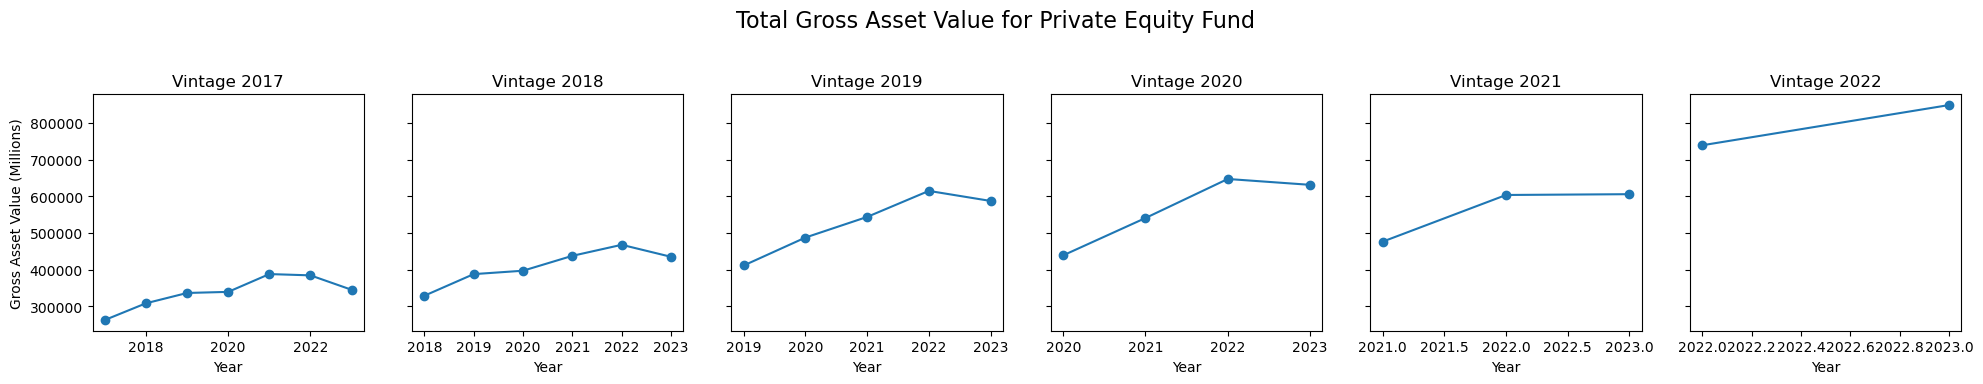

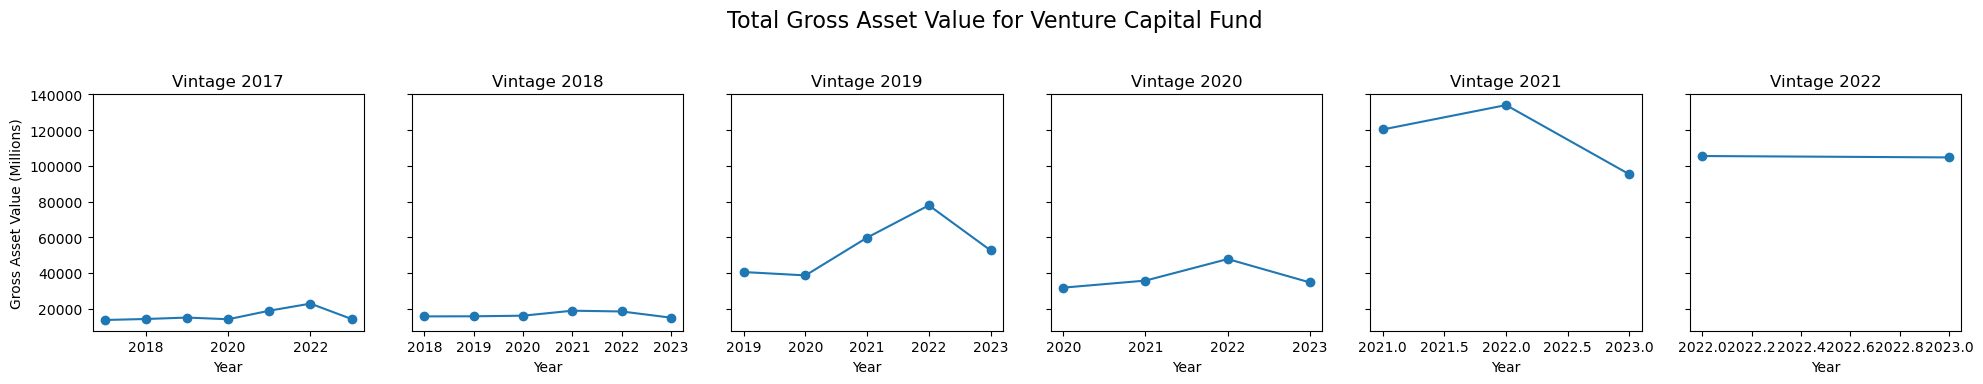

In [18]:
def aggregate_and_plot(df):
              
    # Aggregate gross asset value by vintage year, fund type, and year
    aggregated_df = df.groupby(['vintage', 'fundtype', 'end_date'])['grossassetvalue_m'].sum().reset_index()

    # Plotting
    fund_types = aggregated_df['fundtype'].unique()
    vintage_years = [2017,2018, 2019, 2020, 2021, 2022]

    for fund_type in fund_types:
        fig, axs = plt.subplots(nrows=1, ncols=len(vintage_years), figsize=(20, 4), sharey=True)
        fig.suptitle(f'Total Gross Asset Value for {fund_type}', fontsize=16)

        for i, vintage_year in enumerate(vintage_years):
            ax = axs[i]
            data = aggregated_df[(aggregated_df['fundtype'] == fund_type) & (aggregated_df['vintage'] == vintage_year)]
            ax.plot(data['end_date'], data['grossassetvalue_m'], marker='o')
            ax.set_title(f'Vintage {vintage_year}')
            ax.set_xlabel('Year')
            if i == 0:
                ax.set_ylabel('Gross Asset Value (Millions)')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

aggregate_and_plot(pe_funds)

### Part II


In [19]:
preqin_cf = pd.read_csv('./preqin_cf.csv')
preqin_gps = pd.read_csv('./preqin_gps.csv')
preqin_mgr = pd.read_csv("./preqin_manager.csv")

In [20]:
preqin_gps = preqin_gps[['firm_id', 'fund_id', 'vintage', 'fund_type']]
preqin_mgr = preqin_mgr[['firm_id', 'firmtype', 'firmcountry']]
preqin_cf = preqin_cf[['firm_id', 'fund_id', 'transaction_date', 'transaction_type', 'transaction_amount']]
preqin_cf

,firm_id,fund_id,transaction_date,transaction_type,transaction_amount
0,152327,3,2000-02-14,Capital Call,-13828.54
1,152327,3,2000-02-14,Distribution,28595.60
2,152327,3,2000-03-31,Value,6300822.41
3,152327,3,2000-05-15,Distribution,86105.41
4,152327,3,2000-06-30,Value,6266071.73
...,...,...,...,...,...
372954,11998,162480,2021-12-31,Value,7326064.33
372955,11998,162480,2022-03-31,Value,7553331.08
372956,11998,162480,2022-06-30,Value,6451165.53
372957,11998,162480,2022-08-15,Capital Call,-2435331.32


In [21]:
preqin_gps

,firm_id,fund_id,vintage,fund_type
0,152327,2,1989.0,Buyout
1,152327,3,1993.0,Buyout
2,152327,4,1998.0,Buyout
3,741,7,1995.0,Buyout
4,741,8,1998.0,Buyout
...,...,...,...,...
62617,397610,186407,2024.0,Early Stage
62618,617845,186433,2024.0,Early Stage: Start-up
62619,273974,186434,2016.0,Early Stage: Seed
62620,370279,186435,2022.0,Venture (General)


In [22]:
preqin_mgr = preqin_mgr[(preqin_mgr['firmtype'] == 'Private Equity Firm') & (preqin_mgr['firmcountry']== 'US')]
preqin_mgr

,firm_id,firmtype,firmcountry
6,53,Private Equity Firm,US
8,11,Private Equity Firm,US
9,12,Private Equity Firm,US
12,17,Private Equity Firm,US
15,21,Private Equity Firm,US
...,...,...,...
30076,617527,Private Equity Firm,US
30077,617540,Private Equity Firm,US
30079,617696,Private Equity Firm,US
30080,617697,Private Equity Firm,US


In [23]:
def process_data(gp, manager, cf):
    # TODO: Follow these steps to process the data
    # Merge manager data with cf data
    # merged = pd.merge(cf, manager, on='firm_id', how='left')
    merged = pd.merge(cf, manager, on='firm_id', how='inner')

    # Reshape the data using pivot_table to have a column for each transaction type
    merged = merged.pivot_table(
        index=['firm_id', 'fund_id', 'transaction_date'], 
        columns='transaction_type', 
        values='transaction_amount', 
        aggfunc='sum',
        fill_value=0
    ).reset_index()

    # Merge with general partners data
    merged = pd.merge(merged, gp, on=['firm_id', 'fund_id'], how='left')

    # Keep funds that have vintage years 2000 to 2017, inclusive.
    merged = merged[(merged['vintage'] >= 2000) & (merged['vintage'] <= 2017)]

    # Keep fundtypes Buyout, Growth, and any with “early” or “venture” in their string.
    merged = merged[merged['fund_type'].str.contains('Buyout|Growth|early|venture', case=False)]

    # Combine all fund types containing 'early' into 'Early Stage'
    merged['fund_type'] = merged['fund_type'].apply(lambda x: 'Early Stage' if 'early' in x.lower() else x)

    # Construct the “fundAge” variable that is the year minus the fund vintage.
    merged['fund_age'] = merged['transaction_date'].str[:4].astype(int) - merged['vintage']

    # Convert cash flows from dollars to millions
    for col in ['Capital Call', 'Distribution', 'Value']:
        if col in merged.columns:
            merged[col] = merged[col]/1e6
            merged[col] = merged[col].abs()
    
    return merged


In [24]:
merged = process_data(preqin_gps,preqin_mgr,preqin_cf)
merged

,firm_id,fund_id,transaction_date,Capital Call,Distribution,Value,vintage,fund_type,fund_age
0,11,5365,2005-08-15,1.432618,0.000000,0.000000,2005.0,Buyout,0.0
1,11,5365,2005-09-30,0.000000,0.000000,1.269954,2005.0,Buyout,0.0
2,11,5365,2005-11-15,0.204800,0.000000,0.000000,2005.0,Buyout,0.0
3,11,5365,2005-12-31,0.000000,0.000000,1.425184,2005.0,Buyout,0.0
4,11,5365,2006-02-14,0.850572,0.000000,0.000000,2005.0,Buyout,1.0
...,...,...,...,...,...,...,...,...,...
87531,413355,60732,2022-03-31,0.000000,0.000000,10.956576,2016.0,Growth,6.0
87532,413355,60732,2022-05-15,0.086262,0.003397,0.000000,2016.0,Growth,6.0
87533,413355,60732,2022-06-30,0.000000,0.000000,9.802009,2016.0,Growth,6.0
87534,413355,60732,2022-08-15,0.064974,0.012914,0.000000,2016.0,Growth,6.0


In [25]:
# Create 'net' cash flow and 'cumulative cash flow'
merged['yyyymm'] = merged['transaction_date'].str.replace('-', '').str[:6]
merged['net_cash_flow'] = merged['Distribution'] - merged['Capital Call']
merged['cumulative_cf'] = merged.groupby(['fund_id'])['net_cash_flow'].cumsum()
merged

,firm_id,fund_id,transaction_date,Capital Call,Distribution,Value,vintage,fund_type,fund_age,yyyymm,net_cash_flow,cumulative_cf
0,11,5365,2005-08-15,1.432618,0.000000,0.000000,2005.0,Buyout,0.0,200508,-1.432618,-1.432618
1,11,5365,2005-09-30,0.000000,0.000000,1.269954,2005.0,Buyout,0.0,200509,0.000000,-1.432618
2,11,5365,2005-11-15,0.204800,0.000000,0.000000,2005.0,Buyout,0.0,200511,-0.204800,-1.637418
3,11,5365,2005-12-31,0.000000,0.000000,1.425184,2005.0,Buyout,0.0,200512,0.000000,-1.637418
4,11,5365,2006-02-14,0.850572,0.000000,0.000000,2005.0,Buyout,1.0,200602,-0.850572,-2.487990
...,...,...,...,...,...,...,...,...,...,...,...,...
87531,413355,60732,2022-03-31,0.000000,0.000000,10.956576,2016.0,Growth,6.0,202203,0.000000,8.018379
87532,413355,60732,2022-05-15,0.086262,0.003397,0.000000,2016.0,Growth,6.0,202205,-0.082865,7.935513
87533,413355,60732,2022-06-30,0.000000,0.000000,9.802009,2016.0,Growth,6.0,202206,0.000000,7.935513
87534,413355,60732,2022-08-15,0.064974,0.012914,0.000000,2016.0,Growth,6.0,202208,-0.052060,7.883453


In [26]:
merged.columns

Index(['firm_id', 'fund_id', 'transaction_date', 'Capital Call',
       'Distribution', 'Value', 'vintage', 'fund_type', 'fund_age', 'yyyymm',
       'net_cash_flow', 'cumulative_cf'],
      dtype='object')

#### For each fund, we want to know the age when this cumulative cash flow turned positive. Save this as “year_cf_positive”.

#### a) [12 points] Summarize the positive CF data in the following way. For each fund type and vintage year, report the average fund age funds in that group had positive cumulate CFs. Note that some funds do not ever reach this stage. Similarly, report the fraction of funds that ever had a positive cash flow by fund type and vintage. Plot these two time series vintage year and fund type. You will have two figures with 4 subfigures .

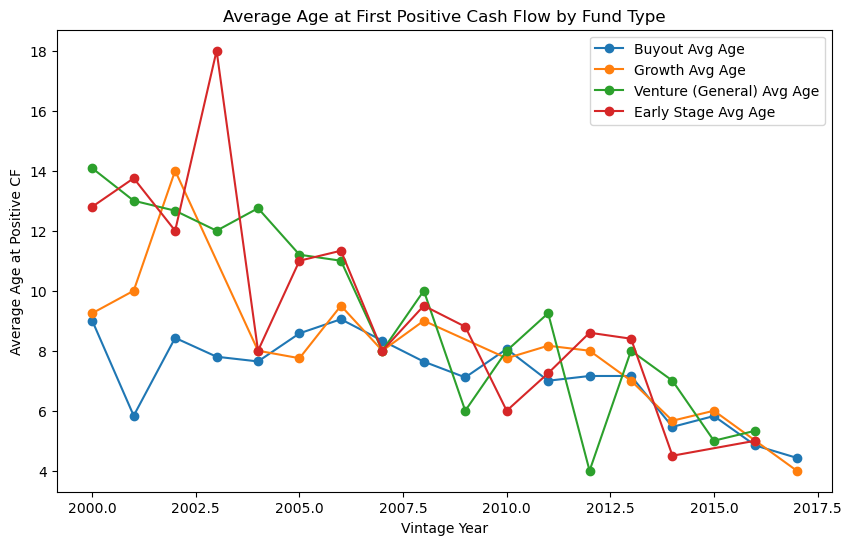

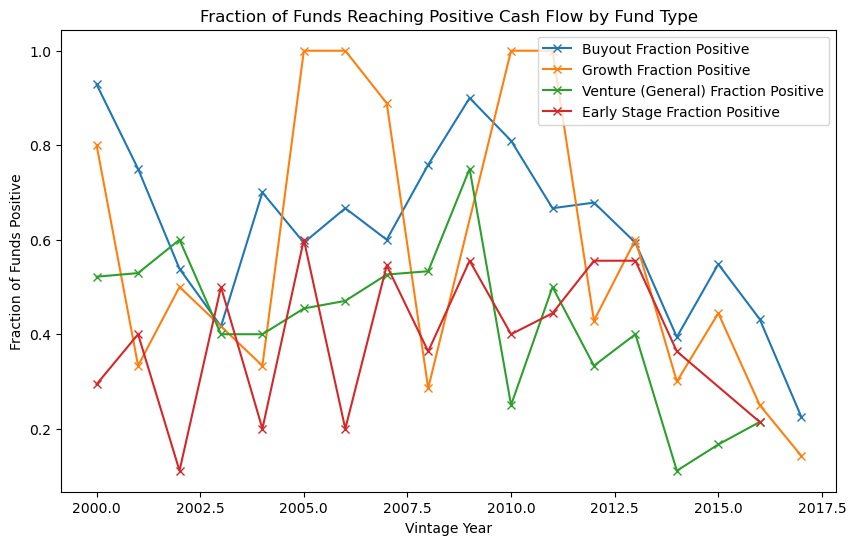

In [27]:

df = merged.copy()

# Part (a) - Calculating the year funds first have a positive cumulative cash flow
df['positive_cf'] = df['cumulative_cf'] > 0
df_first_positive = df[df['positive_cf']].groupby(['fund_id', 'fund_type', 'vintage']).agg(year_cf_positive=('fund_age', 'min')).reset_index()

# Average fund age at first positive cumulative cash flow
avg_fund_age_positive_cf = df_first_positive.groupby(['fund_type', 'vintage']).agg(avg_age_positive_cf=('year_cf_positive', 'mean'))

# Fraction of funds that reach a positive cash flow
total_funds = df.groupby(['fund_type', 'vintage'])['fund_id'].nunique().reset_index(name='total_funds')
total_positive_funds = df_first_positive.groupby(['fund_type', 'vintage'])['fund_id'].nunique().reset_index(name='positive_funds')
fraction_positive = total_positive_funds.merge(total_funds, on=['fund_type', 'vintage'])
fraction_positive['fraction_positive'] = fraction_positive['positive_funds'] / fraction_positive['total_funds']

# Plotting the average age at positive cash flow
fig, ax = plt.subplots(figsize=(10, 6))
for fund_type in df['fund_type'].unique():
    fund_data = avg_fund_age_positive_cf.loc[fund_type]
    ax.plot(fund_data.index, fund_data['avg_age_positive_cf'], marker='o', label=f'{fund_type} Avg Age')
ax.set_title('Average Age at First Positive Cash Flow by Fund Type')
ax.set_xlabel('Vintage Year')
ax.set_ylabel('Average Age at Positive CF')
ax.legend()
plt.show()

# Plotting the fraction of funds reaching positive cash flow
fig, ax = plt.subplots(figsize=(10, 6))
for fund_type in df['fund_type'].unique():
    fund_fraction = fraction_positive[fraction_positive['fund_type'] == fund_type]
    ax.plot(fund_fraction['vintage'], fund_fraction['fraction_positive'], marker='x', label=f'{fund_type} Fraction Positive')
ax.set_title('Fraction of Funds Reaching Positive Cash Flow by Fund Type')
ax.set_xlabel('Vintage Year')
ax.set_ylabel('Fraction of Funds Positive')
ax.legend()
plt.show()

#### b) [13 points] Now we want to aggregate the cumulative cash flows over all funds by fund age. Report the average cumulative cash flow by fund age (integer), fund type and vintage year. You will create a 2X2 figure for each vintage year. The x-axis is fund age and the y-axis is the cumulative CF. Place a line at y = 0. Each figure will have 4 subfigures for the 4 fund types. An example of such a figure is below:

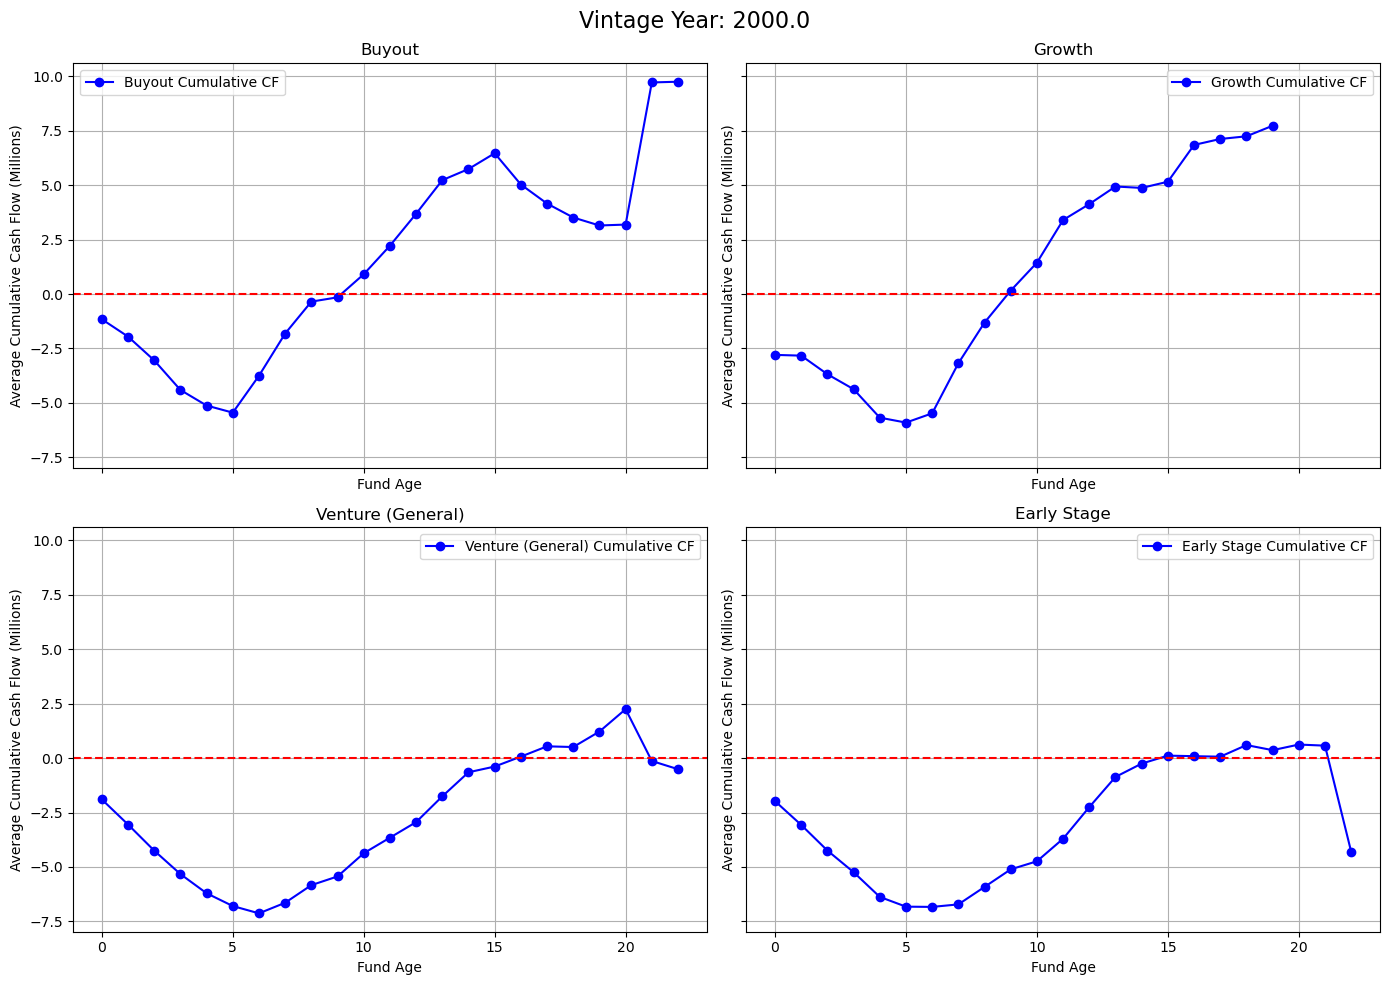

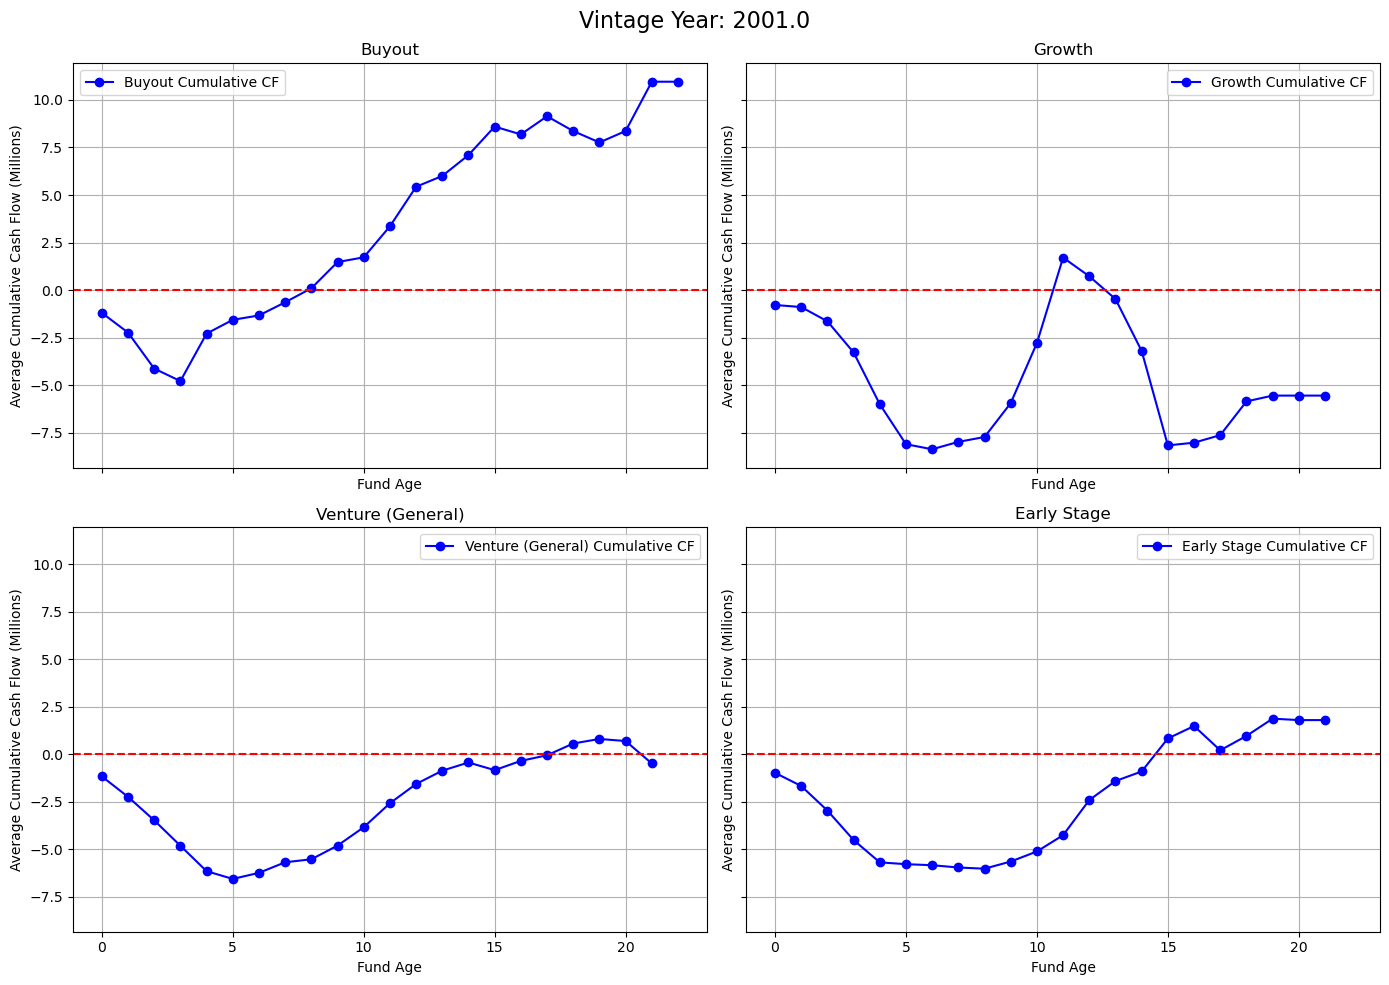

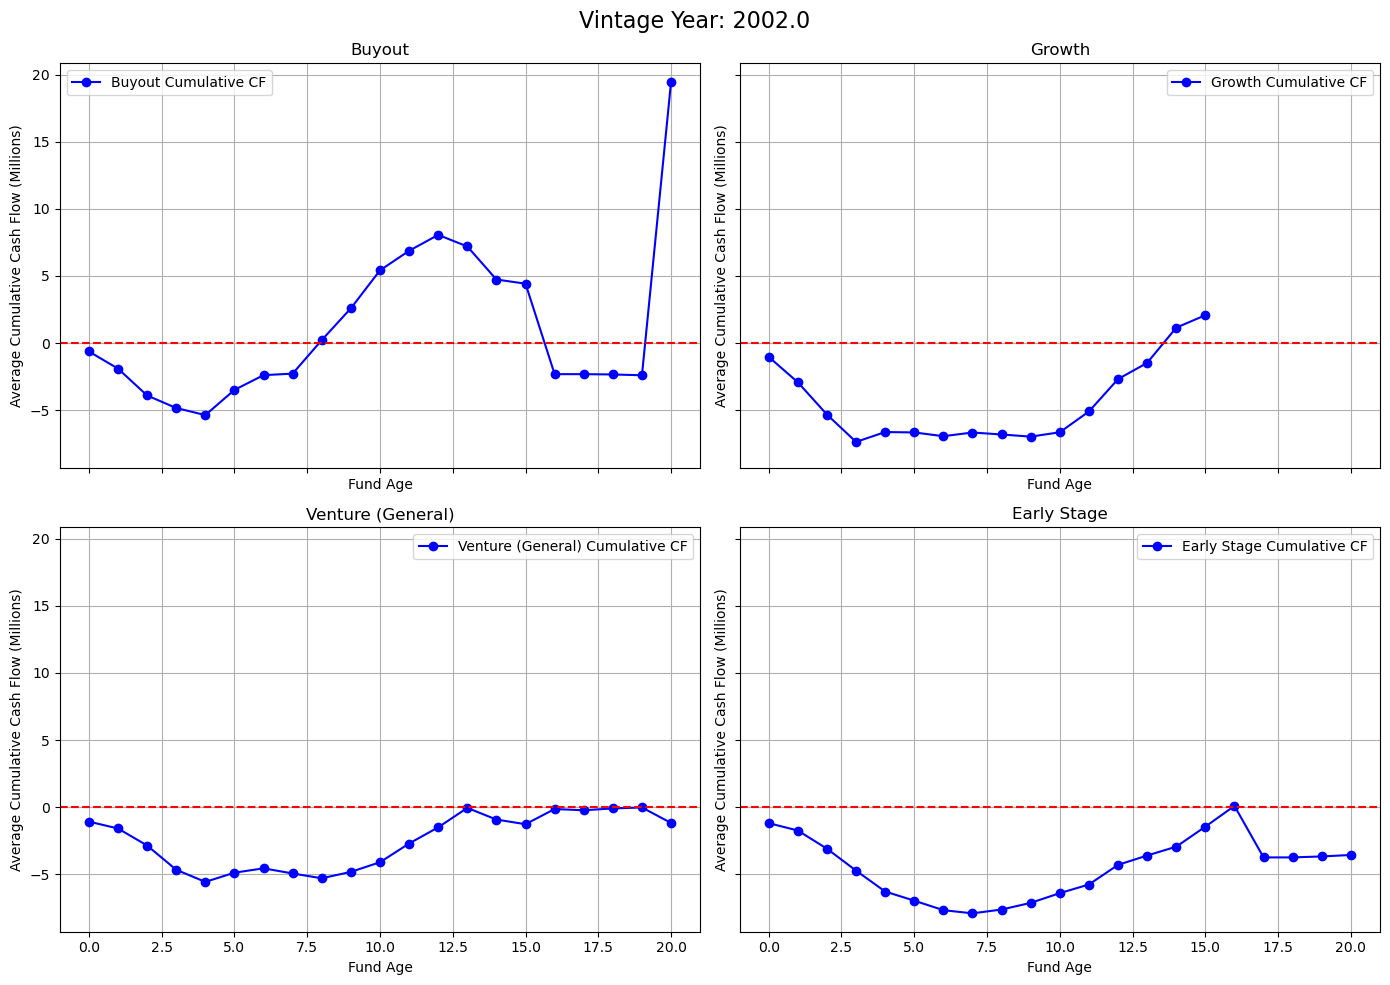

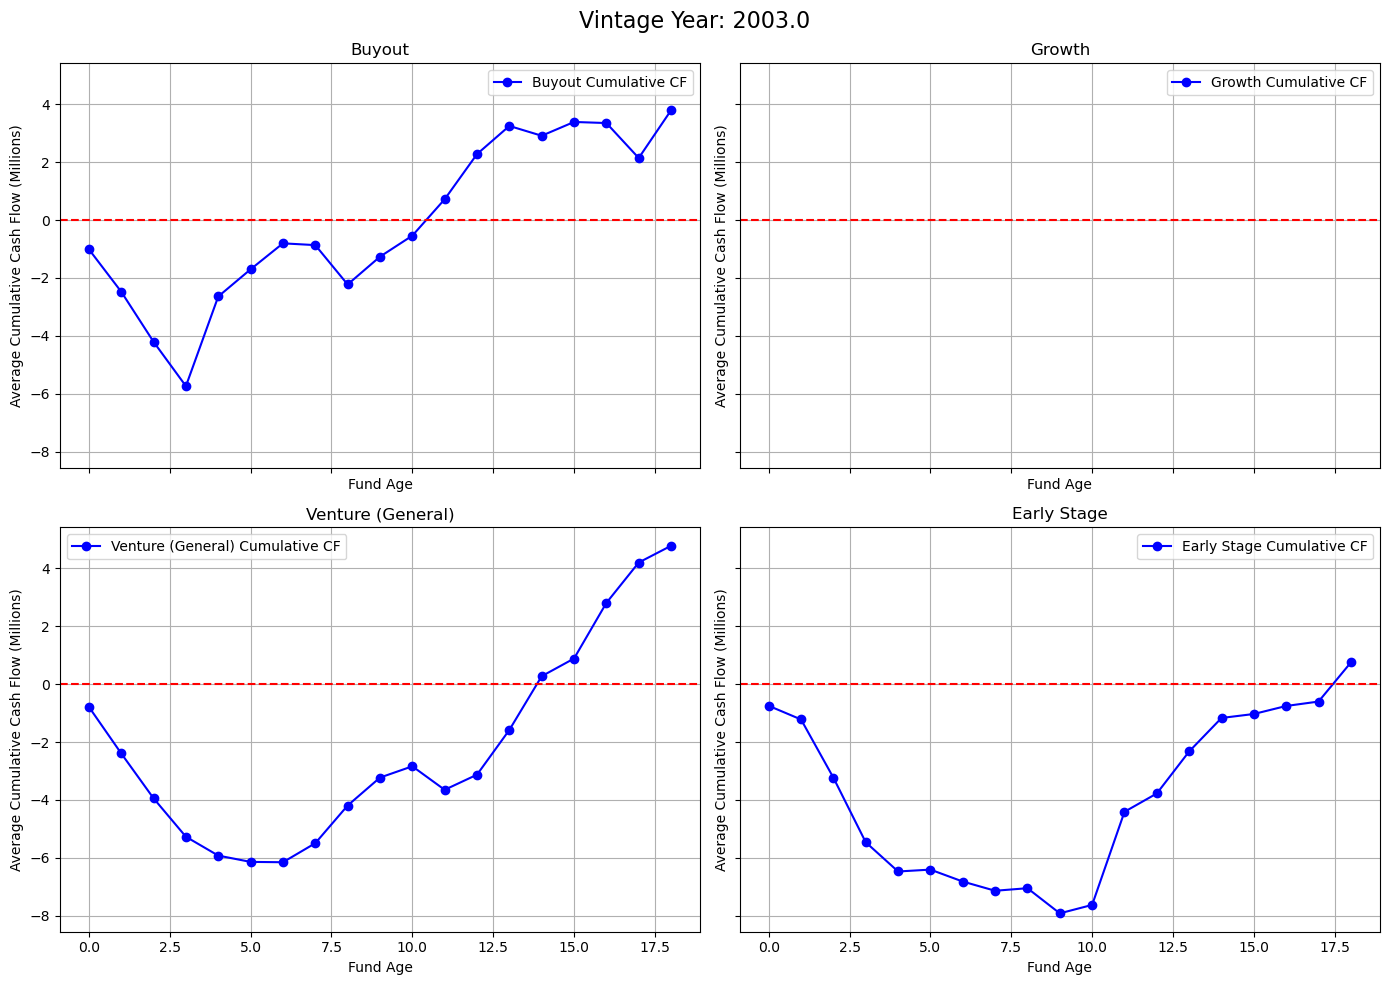

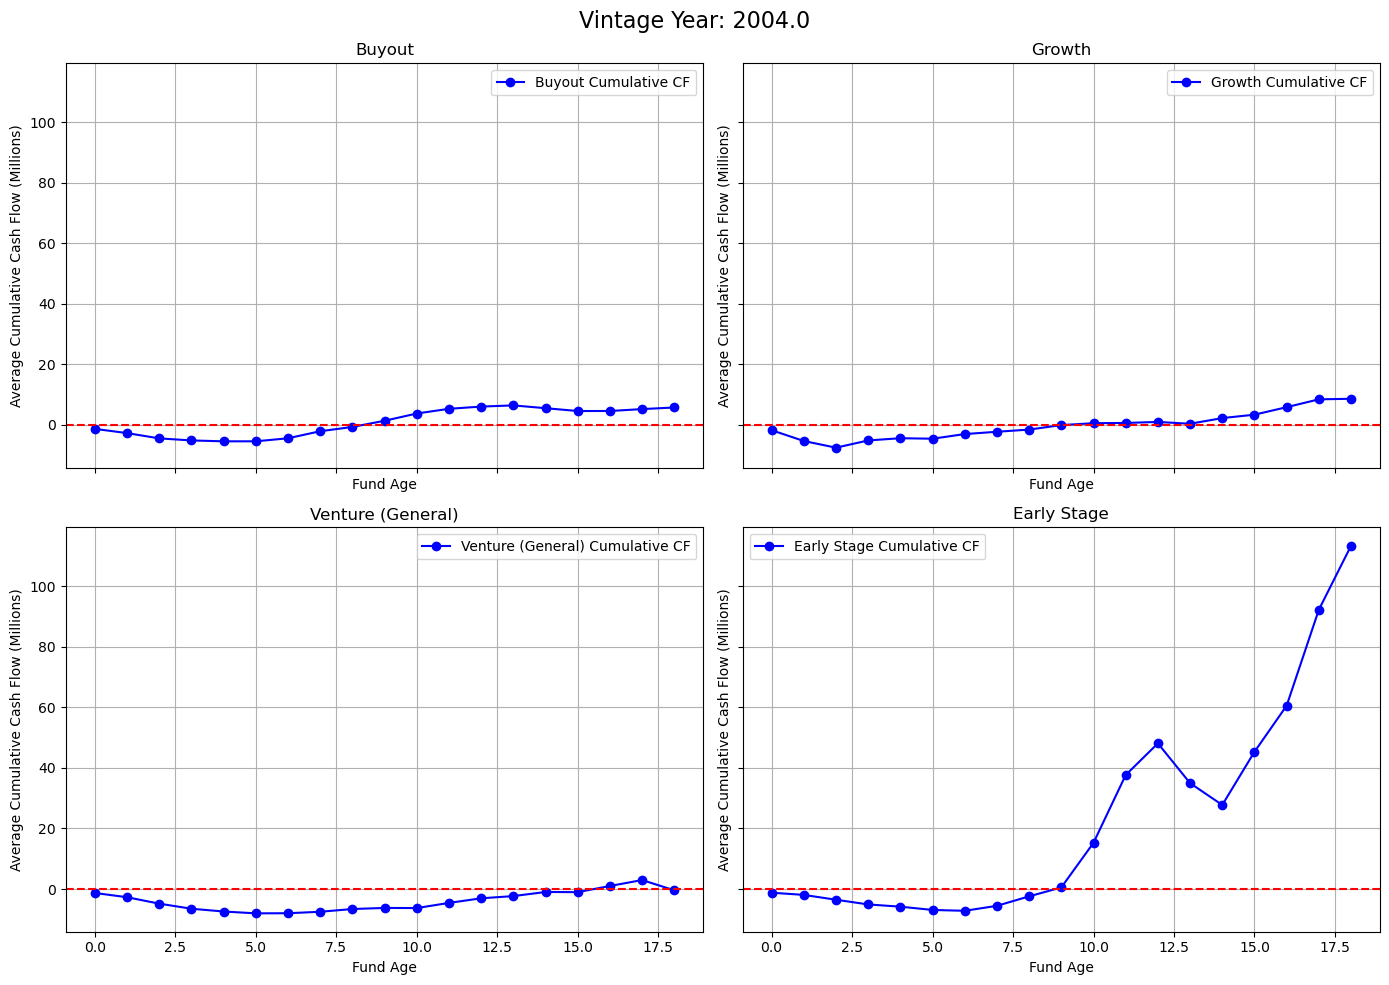

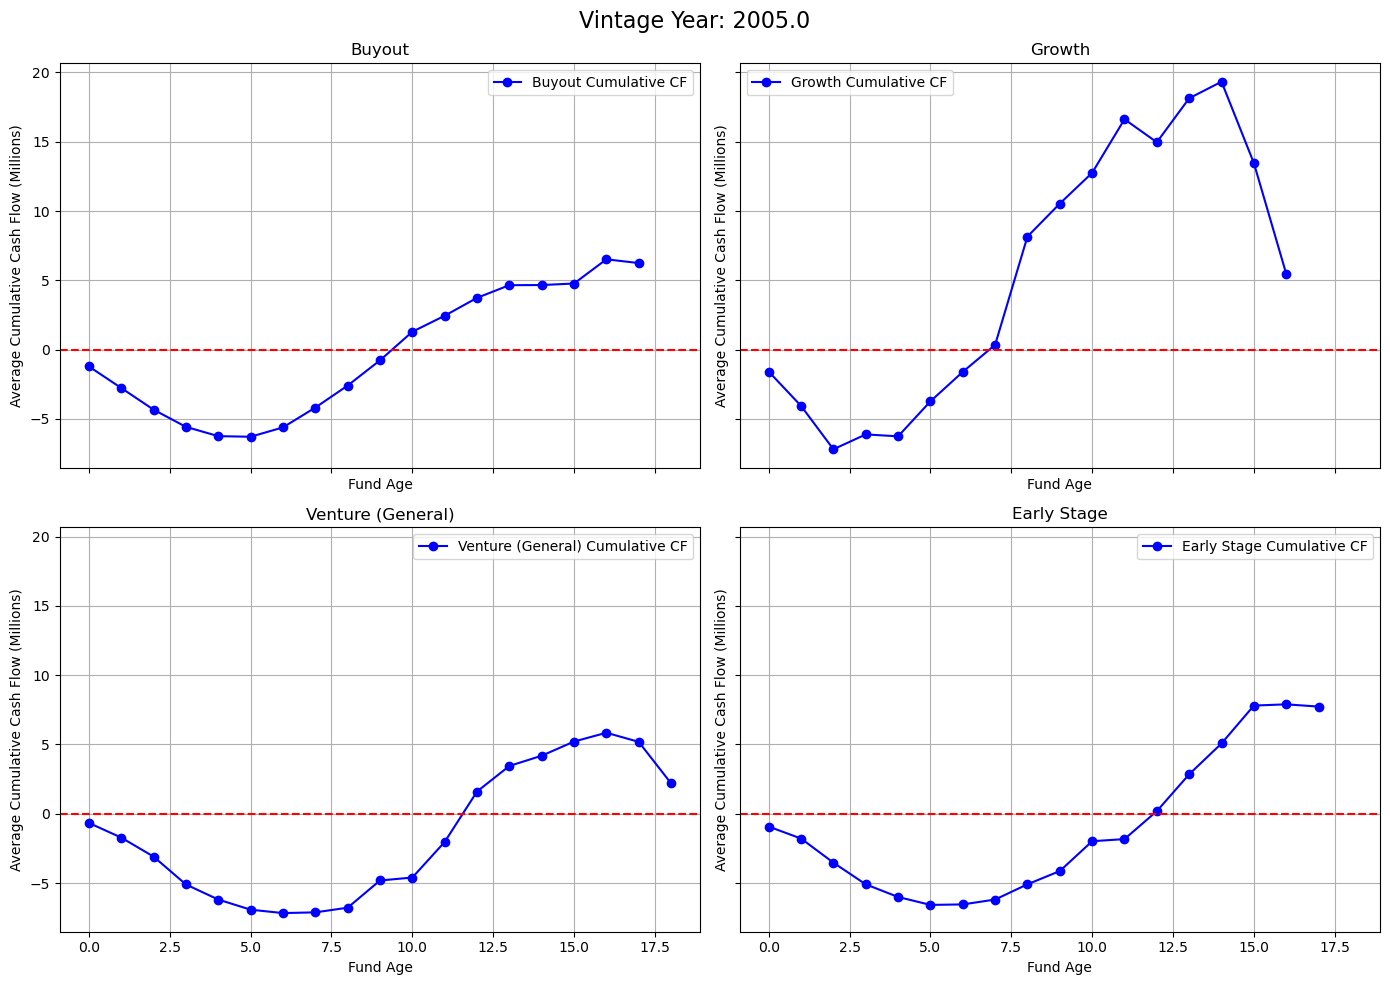

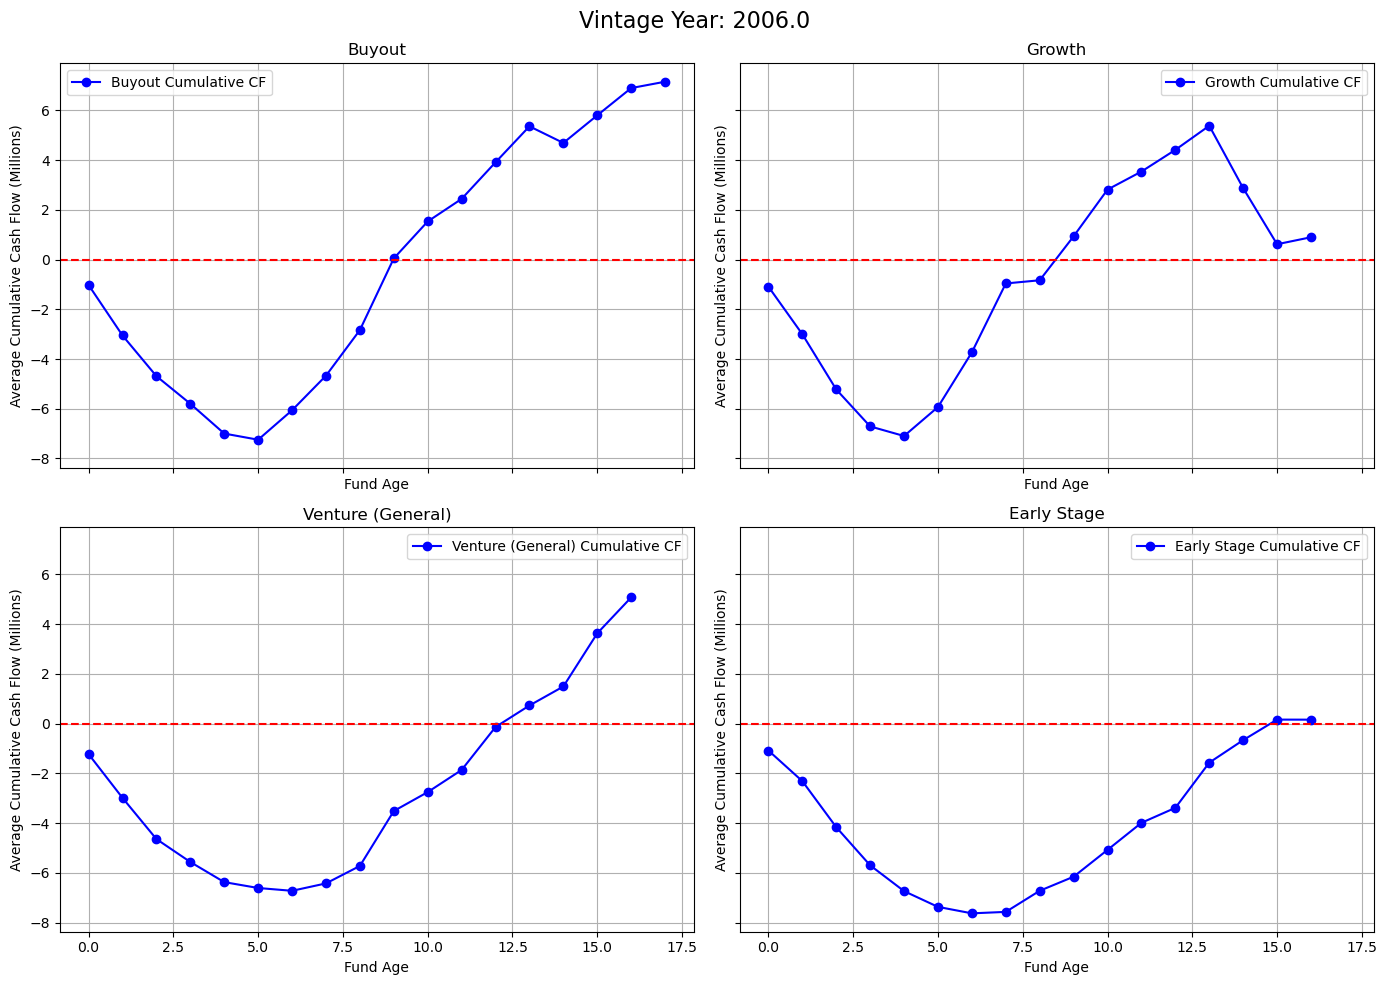

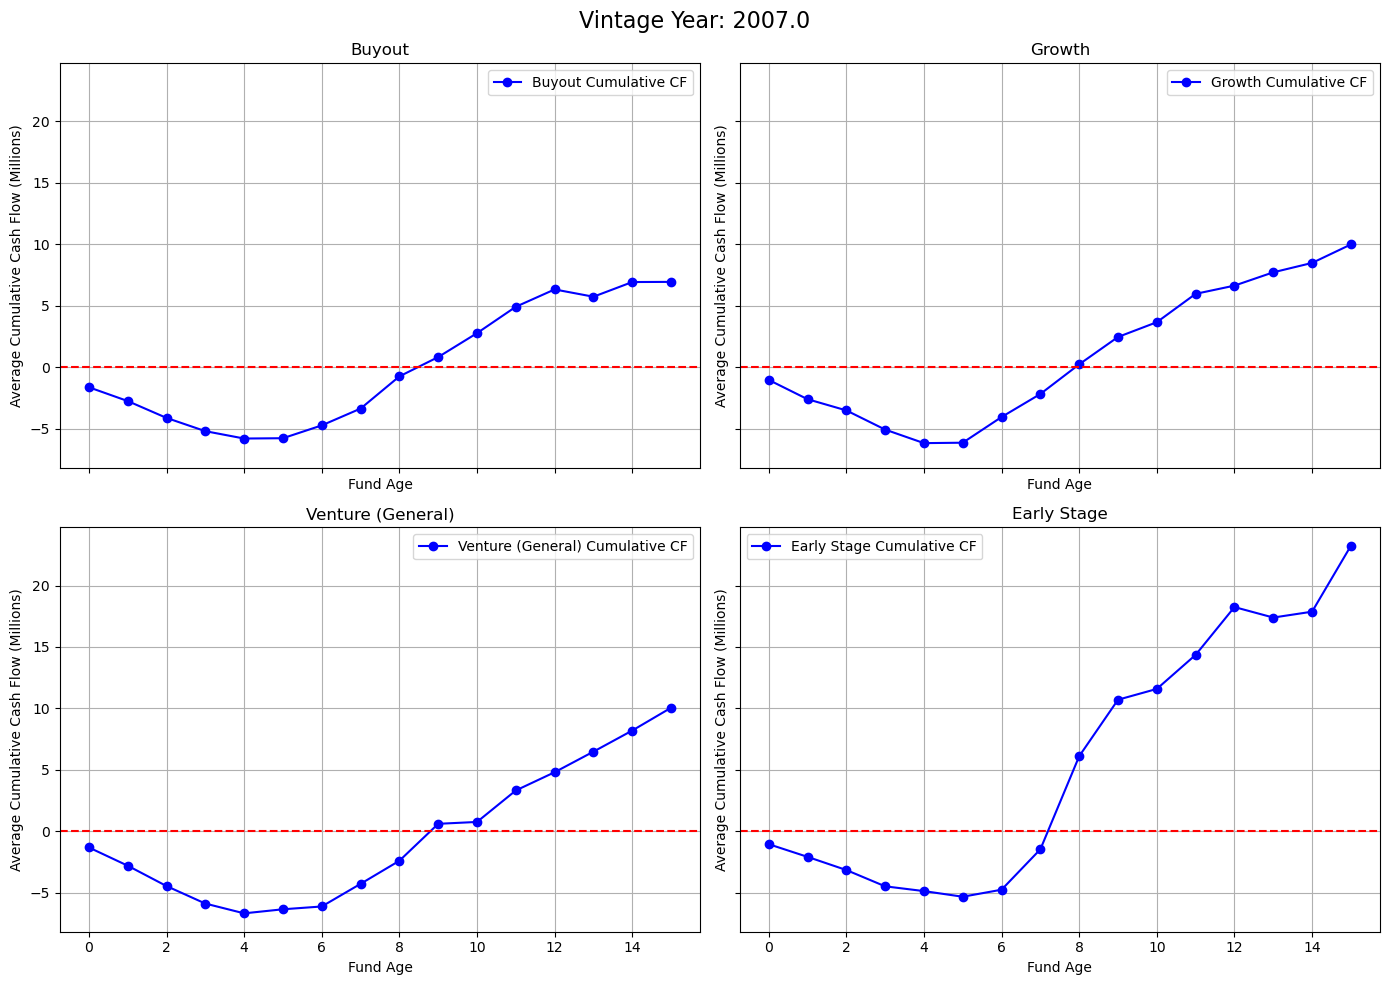

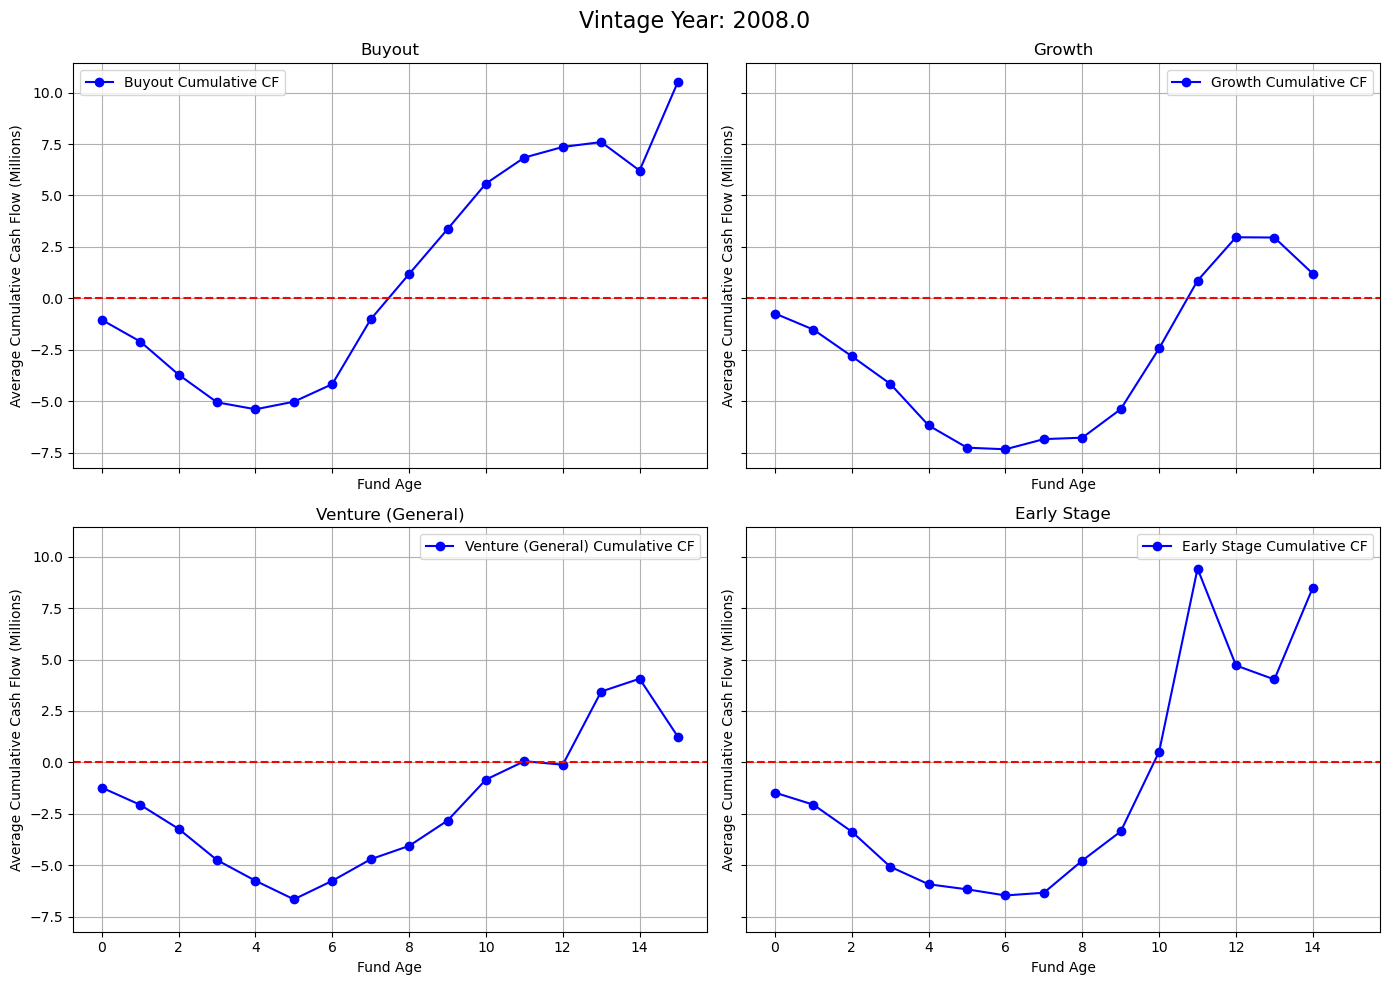

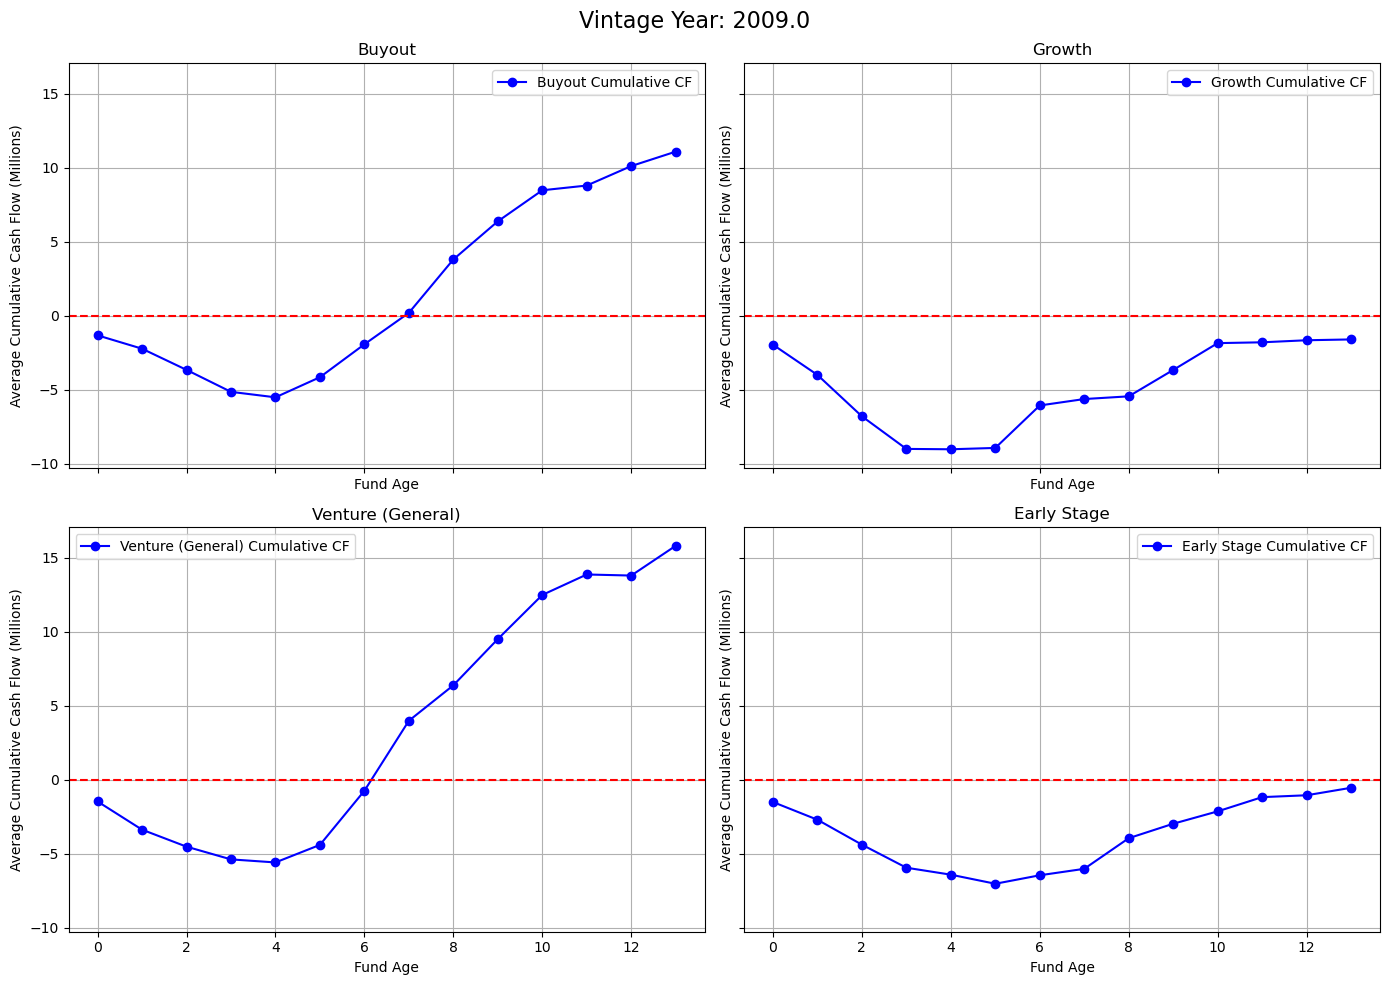

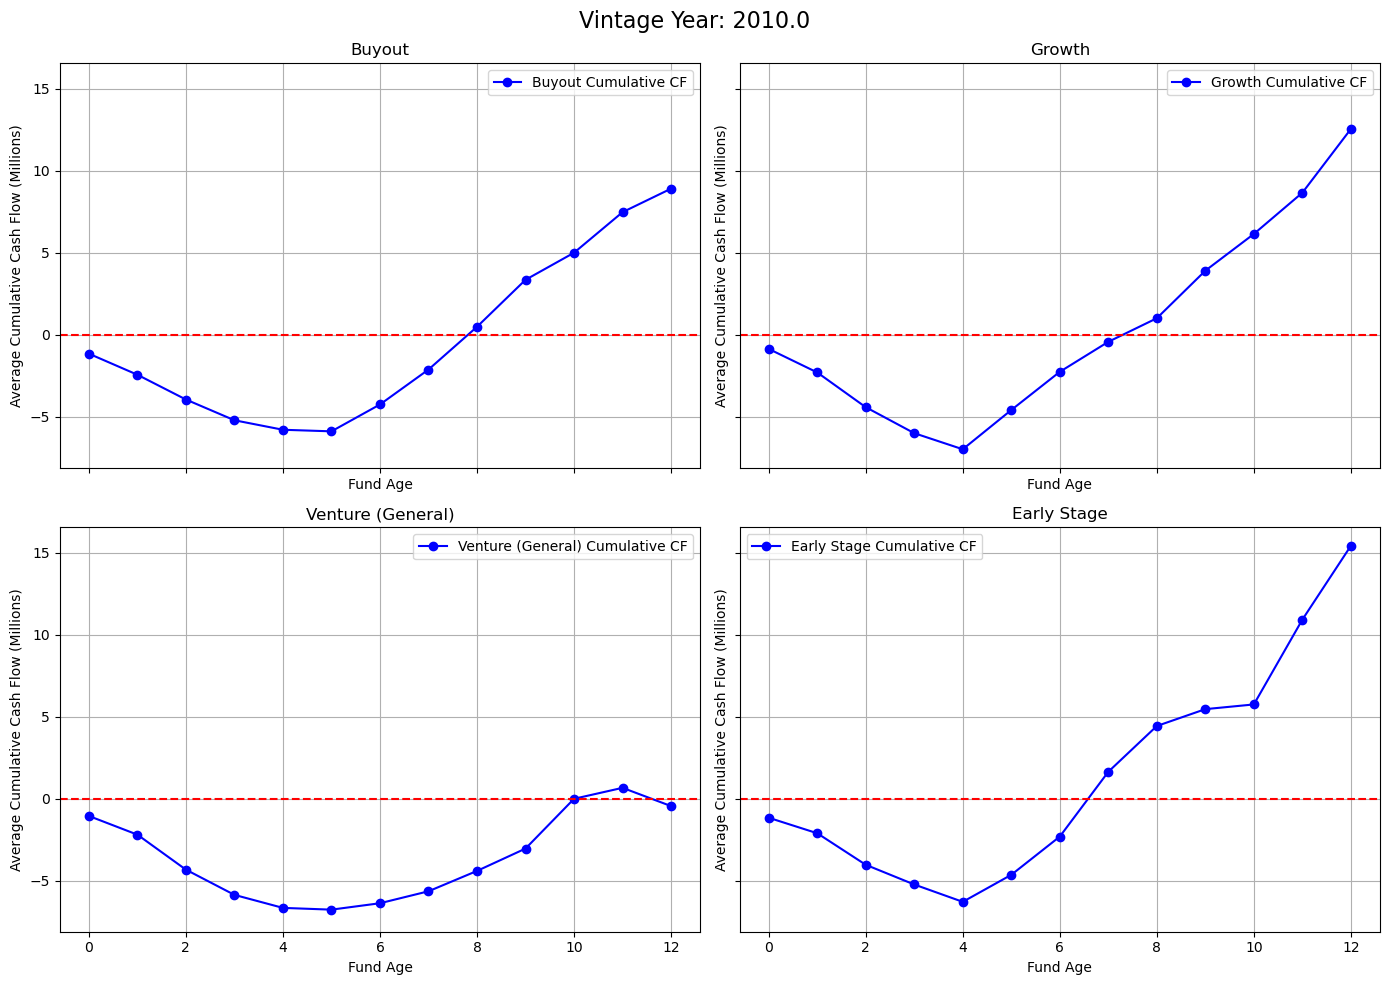

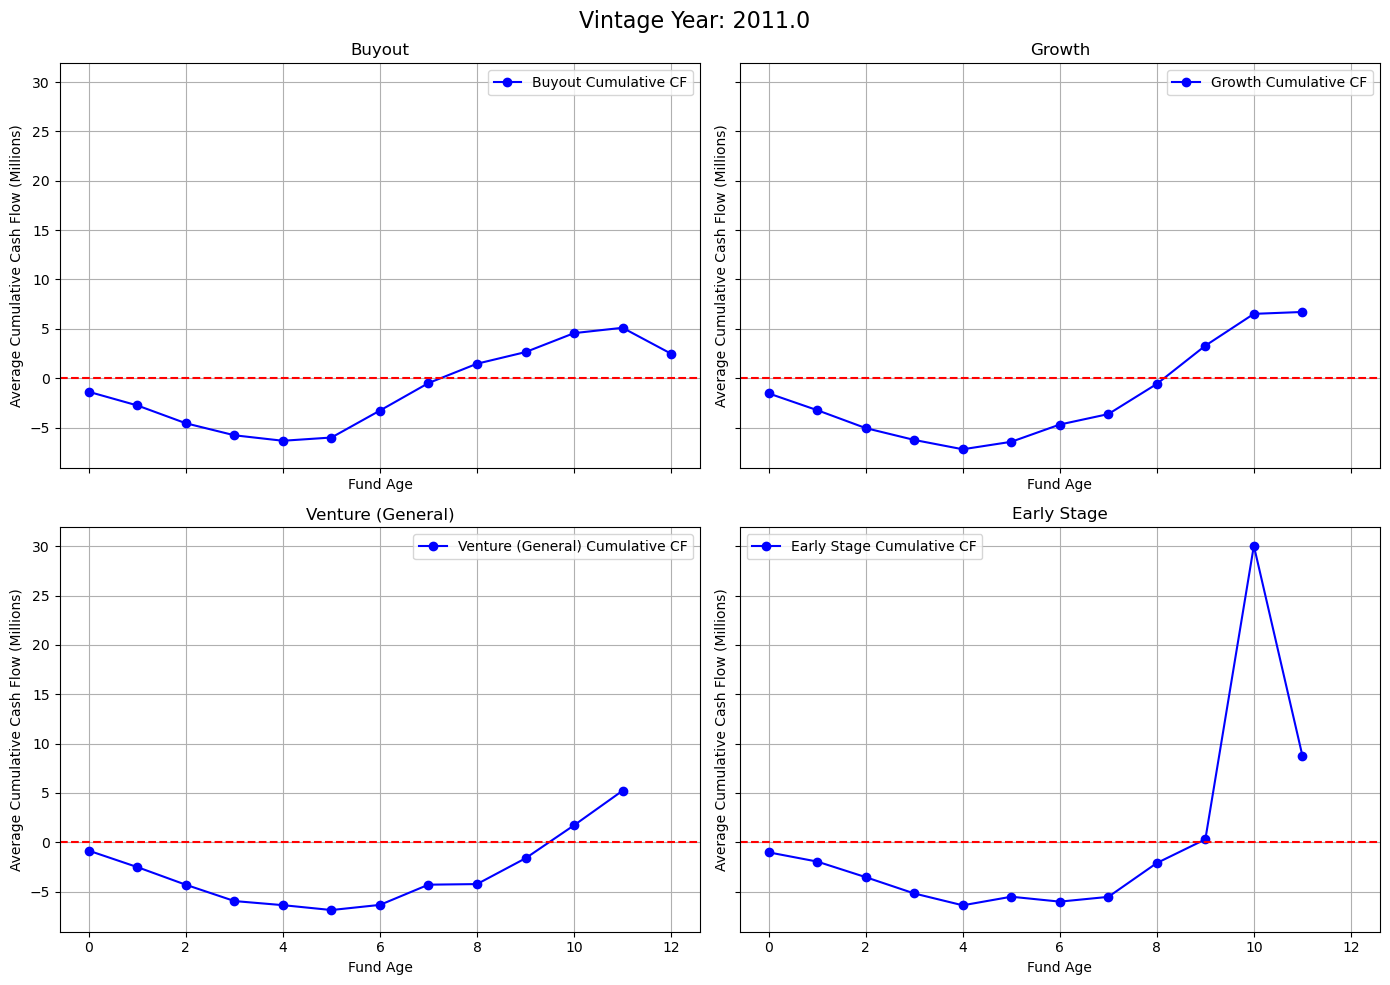

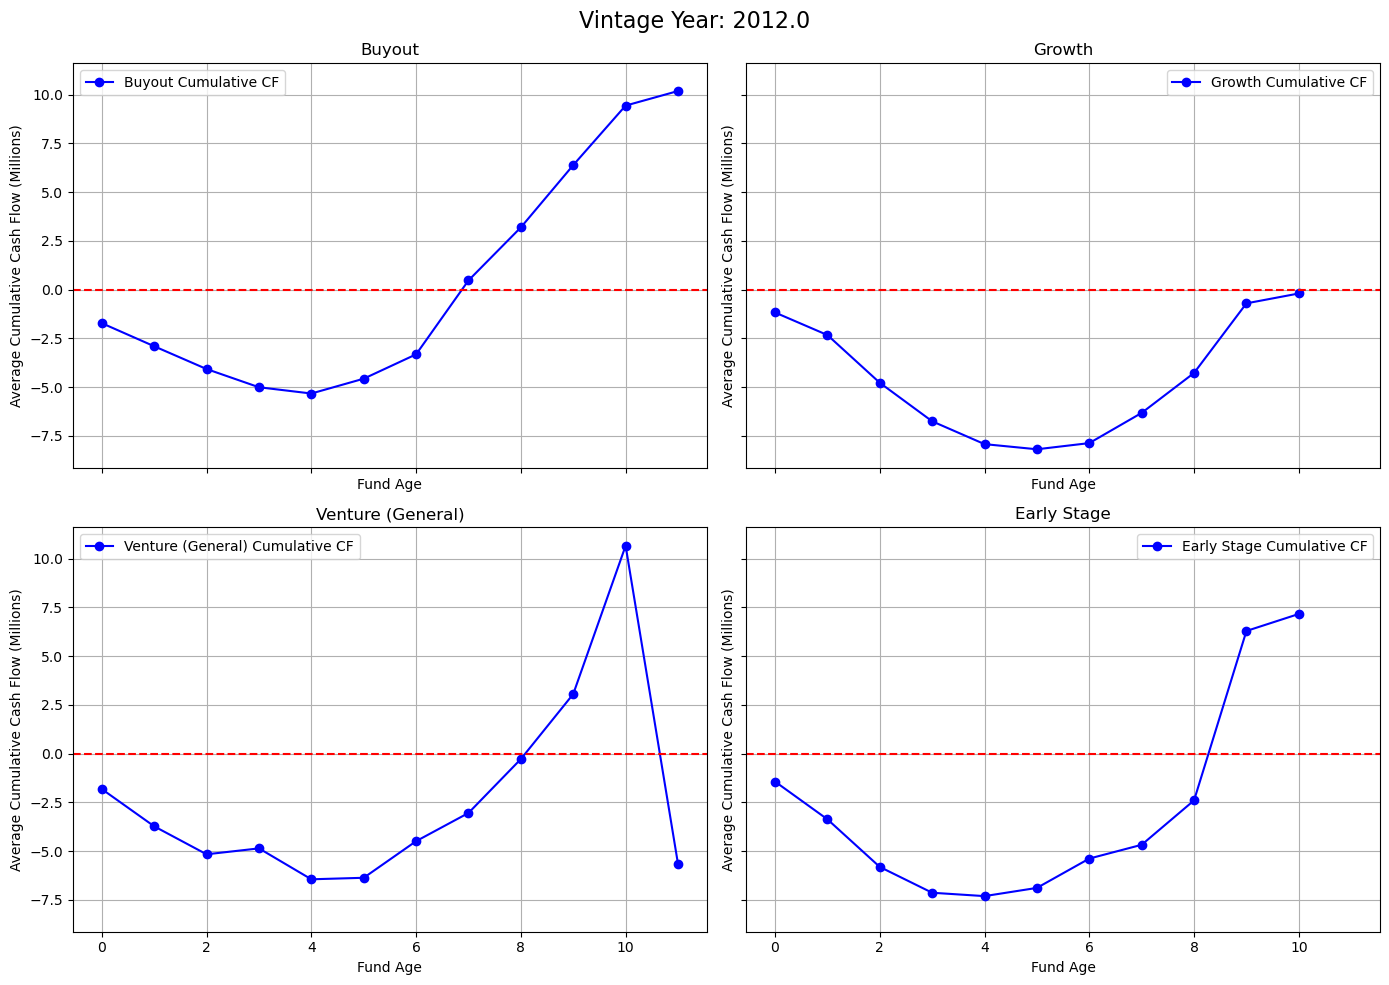

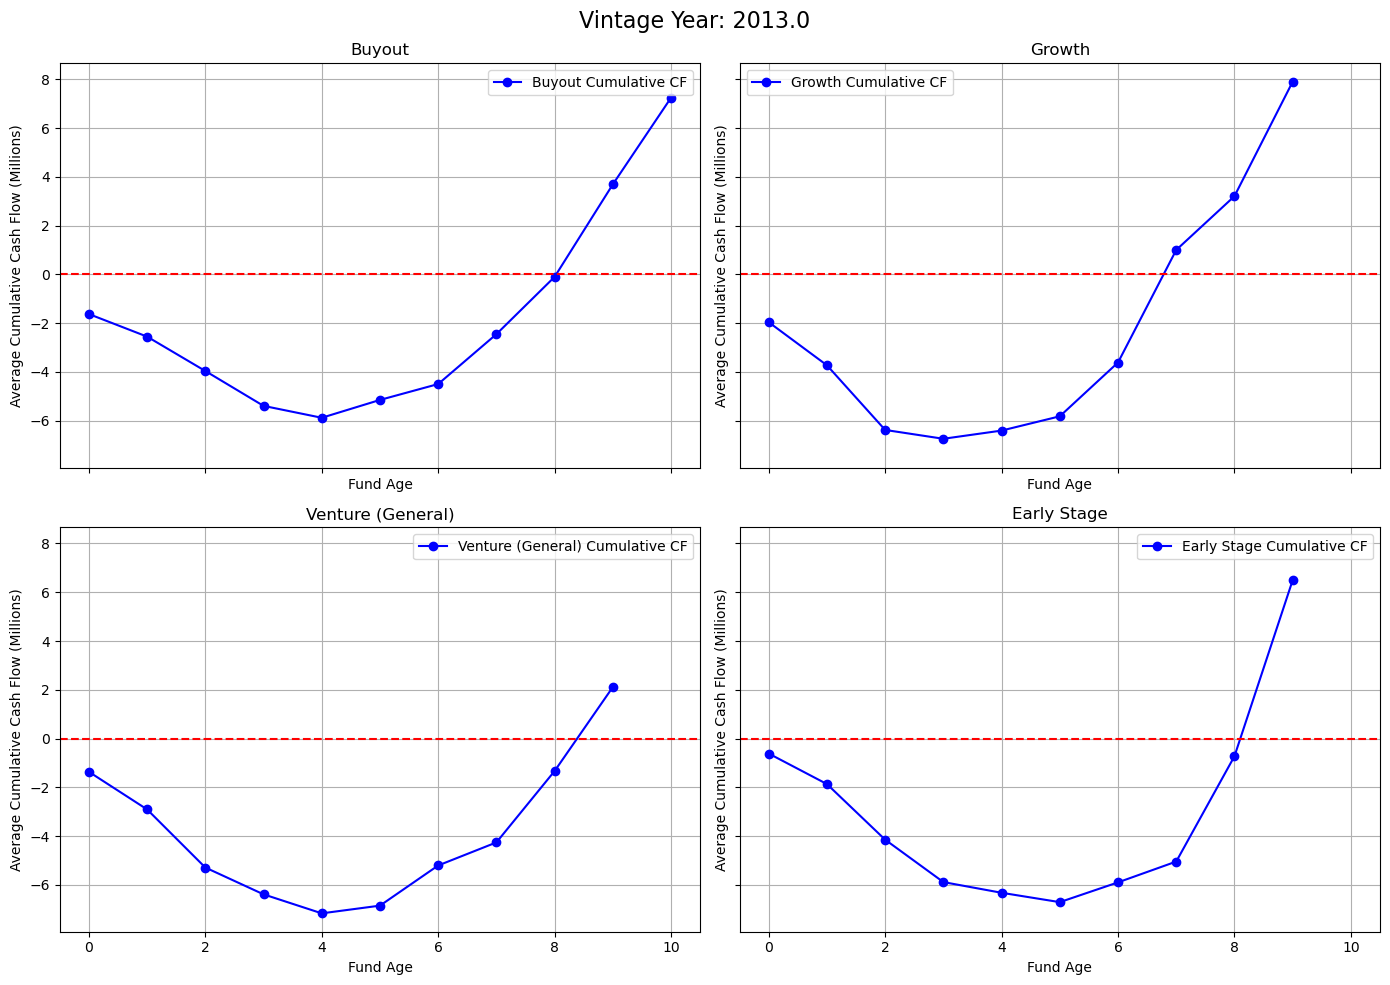

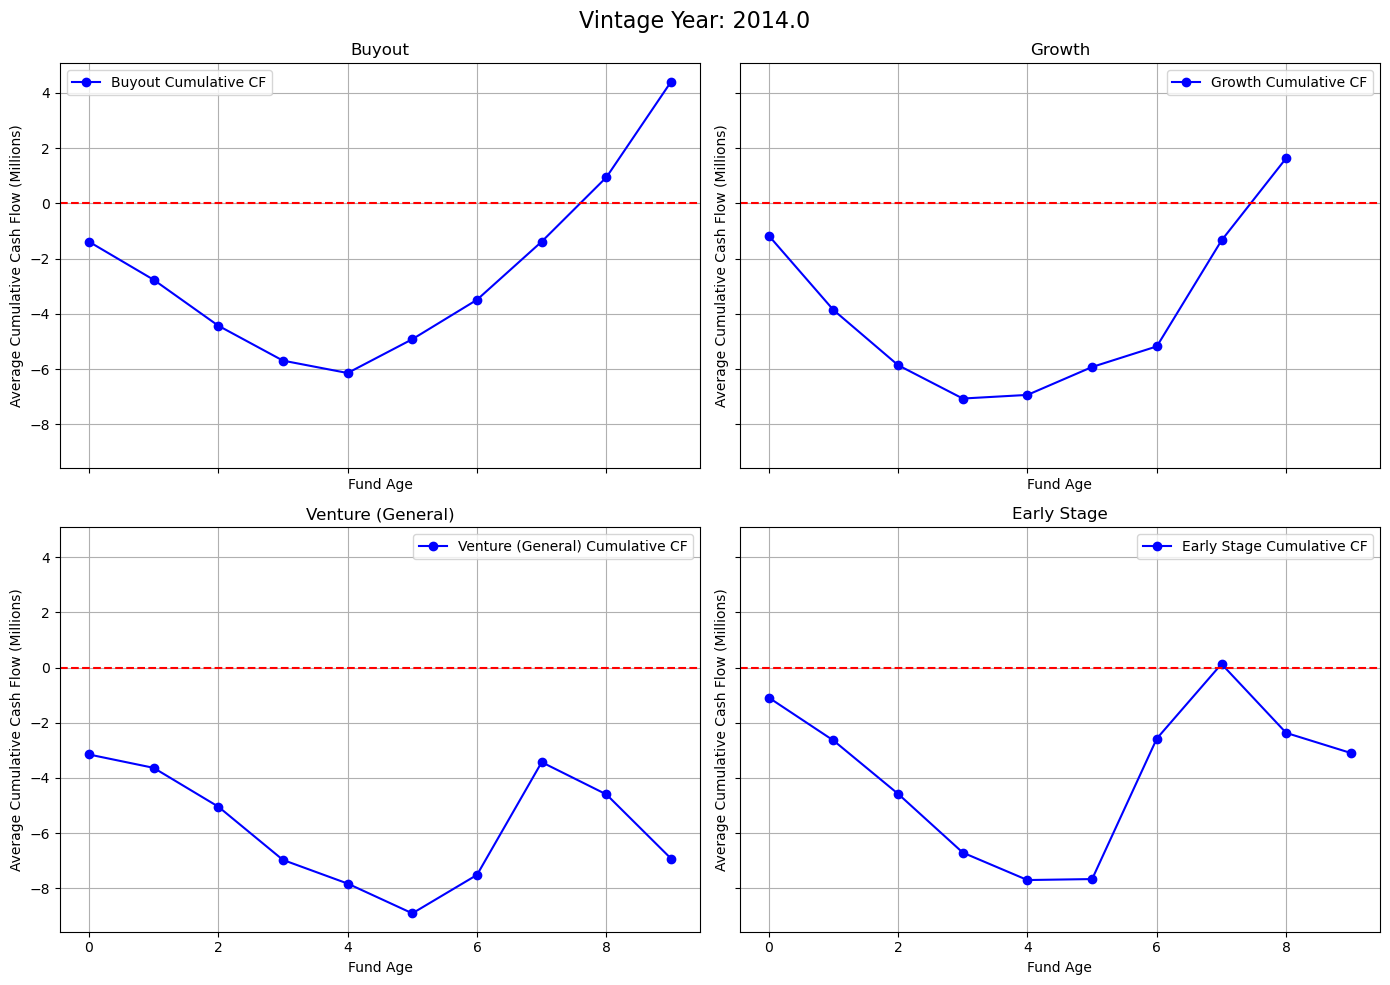

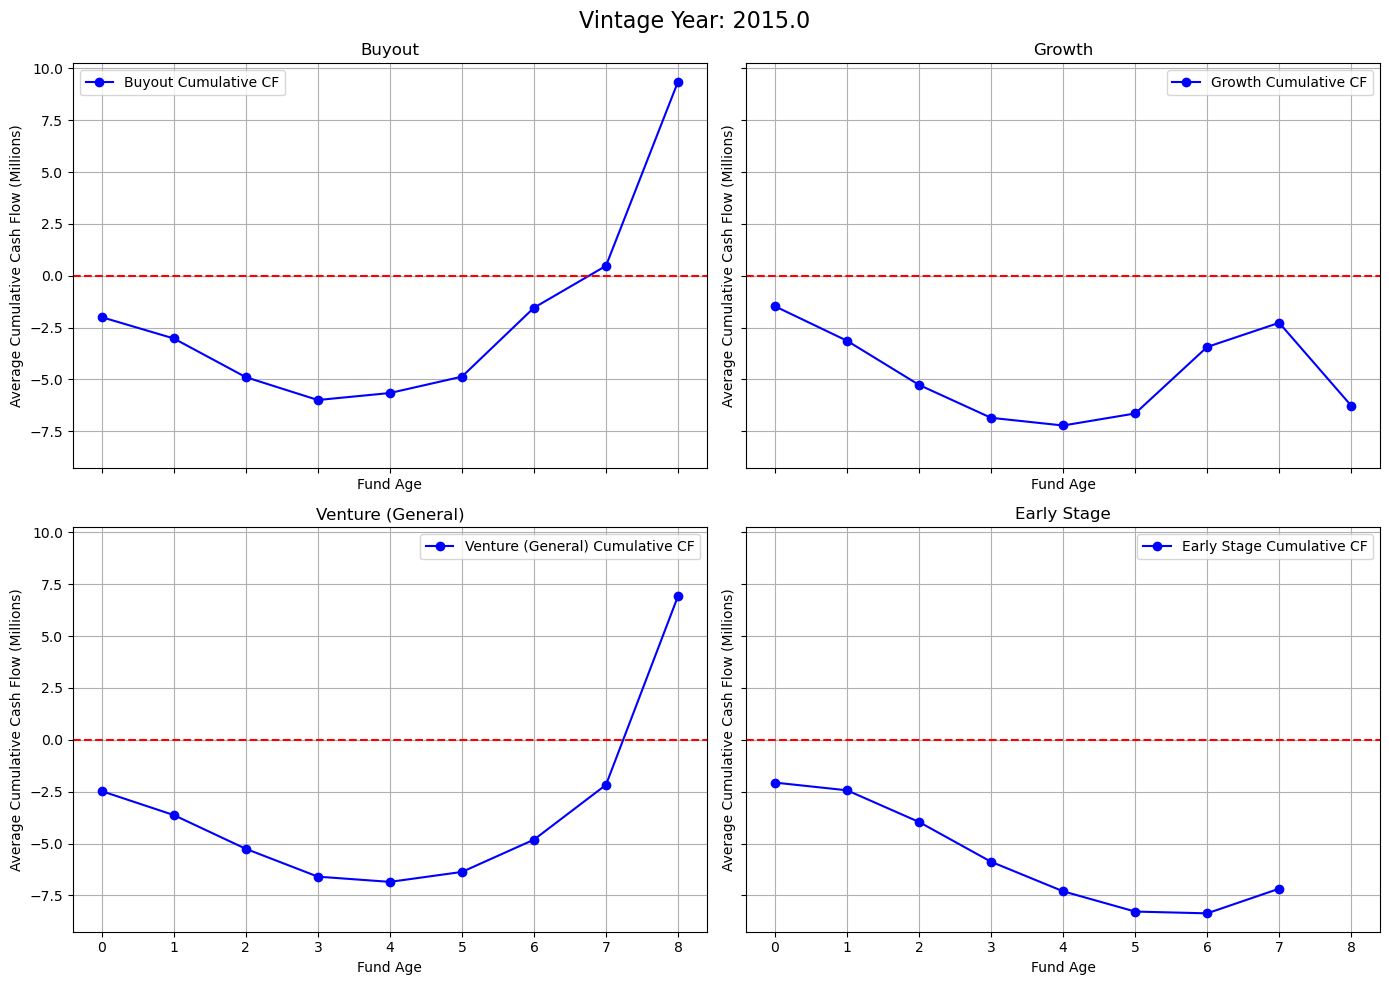

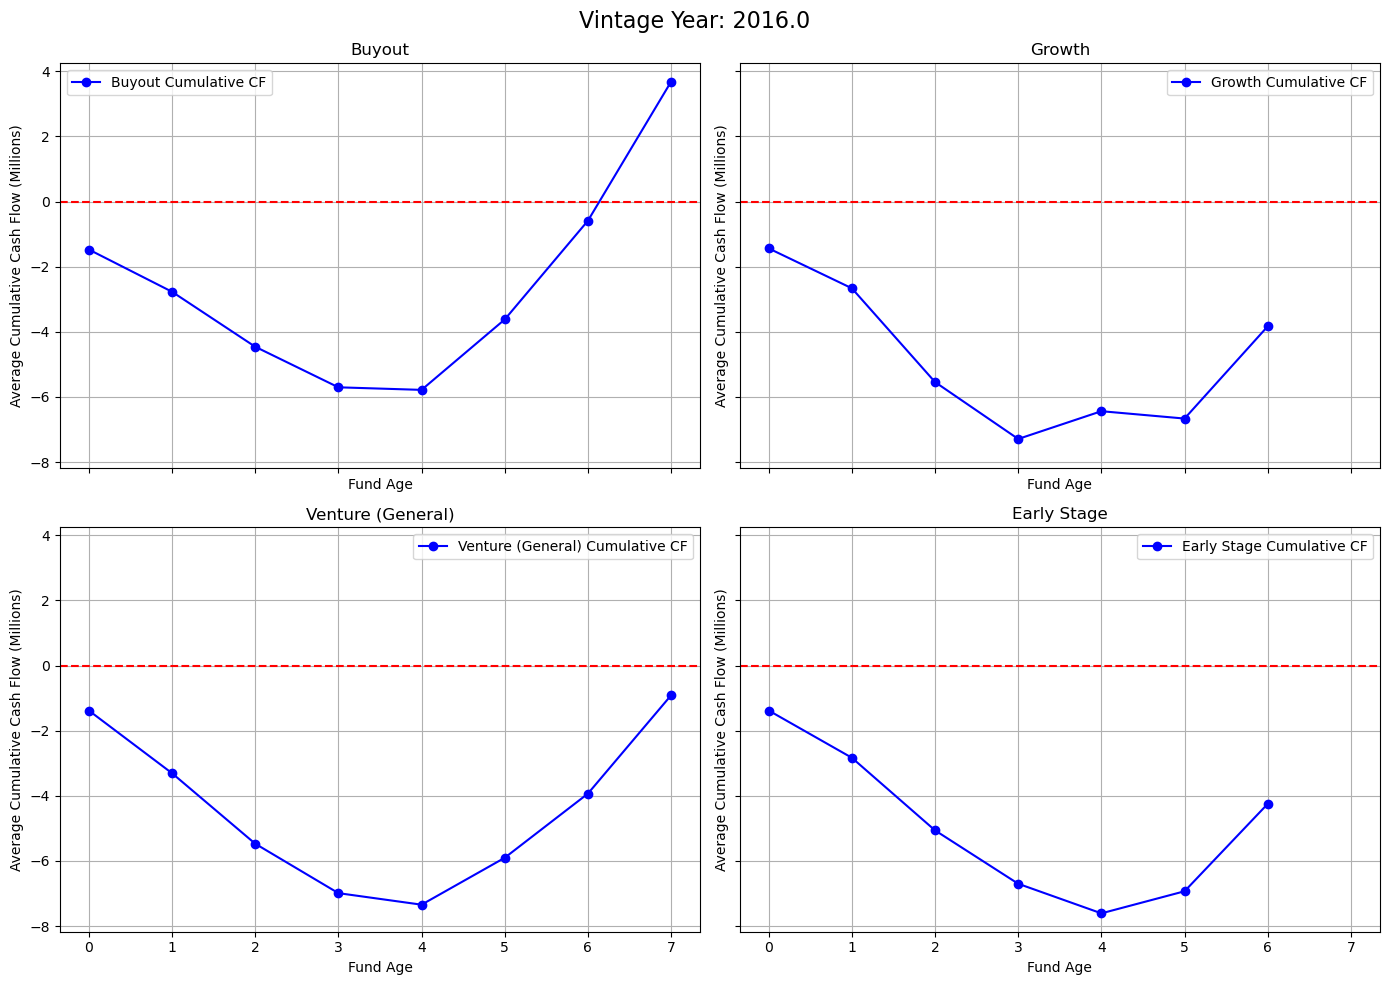

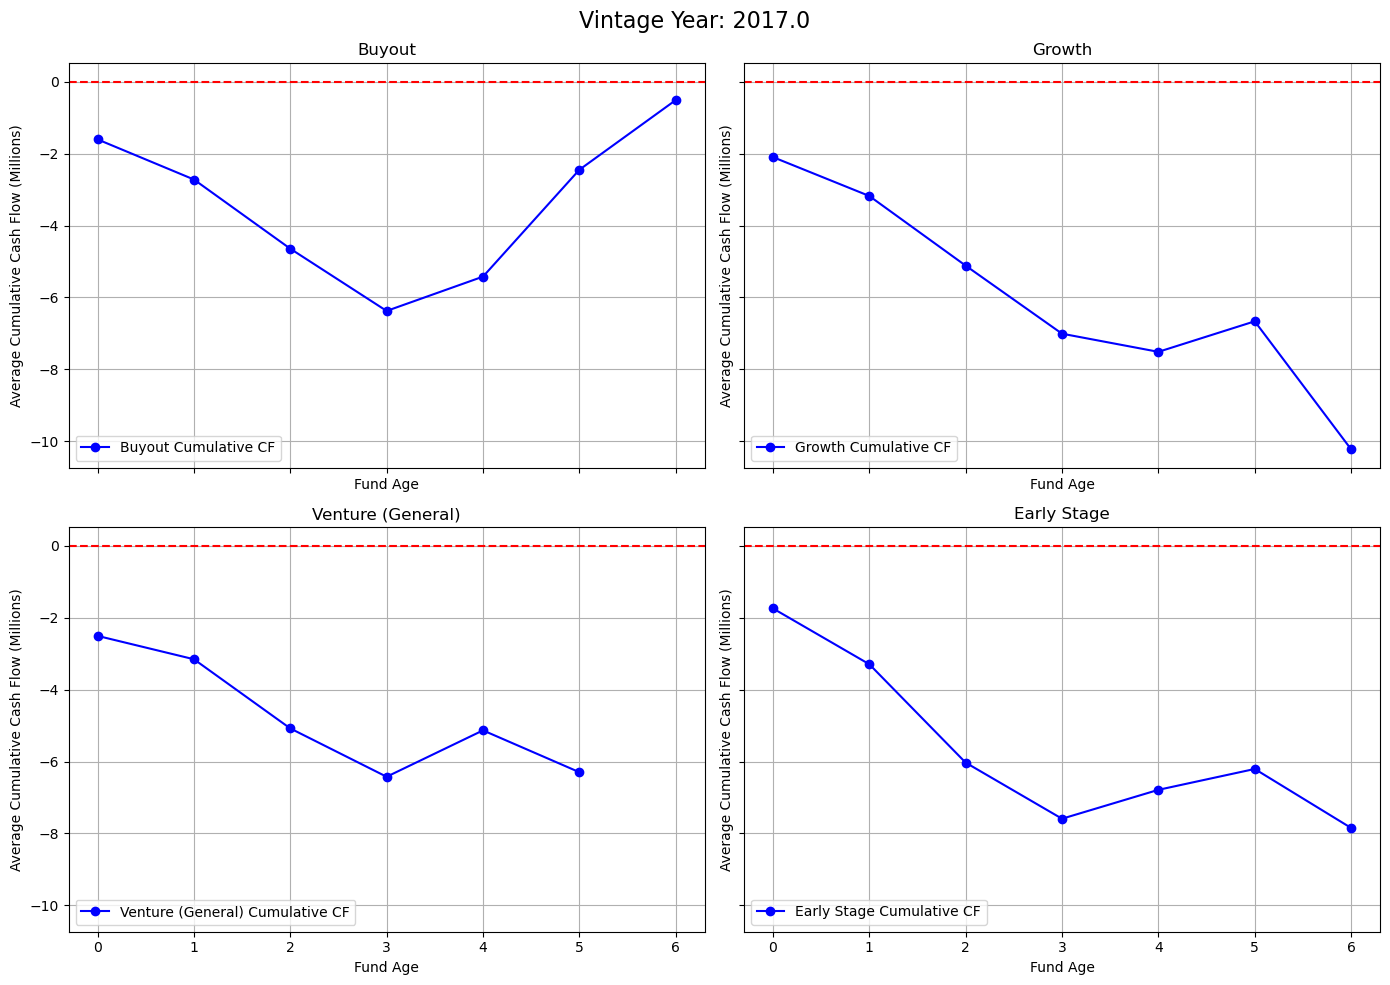

In [28]:
df = merged.copy()

# Part (b) - Aggregate and plot cumulative cash flows
# Group by fund type, vintage year, and fund age to calculate the average cumulative cash flow
avg_cumulative_cf = df.groupby(['fund_type', 'vintage', 'fund_age']).agg(avg_cumulative_cf=('cumulative_cf', 'mean')).reset_index()

# Plotting the cumulative cash flow for each vintage year by fund type
unique_vintages = sorted(df['vintage'].unique())
for vintage in unique_vintages:
    # Create a figure with subplots for each fund type
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True, sharey=True)
    fig.suptitle(f'Vintage Year: {vintage}', fontsize=16)
    
    # Get unique fund types for plotting
    fund_types = df['fund_type'].unique()
    for i, fund_type in enumerate(fund_types):
        ax = axes[i//2, i%2]
        data = avg_cumulative_cf[(avg_cumulative_cf['vintage'] == vintage) & (avg_cumulative_cf['fund_type'] == fund_type)]
        ax.plot(data['fund_age'], data['avg_cumulative_cf'], marker='o', color='blue', label=f'{fund_type} Cumulative CF')
        ax.axhline(0, color='red', linestyle='--')  # Add a horizontal line at zero for reference
        ax.set_title(f'{fund_type}')
        ax.set_xlabel('Fund Age')
        ax.set_ylabel('Average Cumulative Cash Flow (Millions)')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


## Real Estate

In [29]:
file_path = './6_real_estate_data_sample_04082024.csv'
df = pd.read_csv(file_path)
# columns = [ 'loan_id','orig_dt','pay_dt_1','firsttime_buyer', 'orig_intrt', 'orig_upb','orig_cltv','orig_ltv',
#             'dbt_incm_ratio', 'borr_crdt_score','loan_purpose','insurance_percent','unit_num', 
#             'occupancy','loan_term'
# ]
# data = data[columns]
df

,orig_intrt,orig_upb,loan_term,orig_dt,pay_dt_1,orig_ltv,orig_cltv,dbt_incm_ratio,borr_crdt_score,firsttime_buyer,...,zero_bal_date122014,int_rate122015,unpaid_prncpl_bal122015,loan_age122015,mnths_to_maturity122015,maturity_dt122015,msa122015,delinq_status122015,zero_bal_code122015,zero_bal_date122015
0,4.625,280000,360,02/2012,04/2012,31,31,23.0,801.0,N,...,NaN,4.625,262326.09,45.0,315.0,03/2042,41860.0,0,NaN,NaN
1,3.990,466000,360,01/2012,03/2012,80,80,30.0,794.0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.000,229000,360,02/2012,04/2012,67,67,36.0,802.0,N,...,NaN,4.000,212777.00,45.0,315.0,03/2042,49700.0,0,NaN,NaN
3,4.125,154000,360,12/2011,02/2012,77,77,43.0,724.0,N,...,NaN,4.125,142350.70,47.0,313.0,01/2042,14460.0,0,NaN,NaN
4,3.875,152000,360,01/2012,03/2012,48,48,26.0,820.0,N,...,NaN,3.875,140821.50,46.0,314.0,02/2042,40140.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.250,156000,360,02/2012,04/2012,80,80,41.0,702.0,N,...,NaN,4.250,145520.00,45.0,315.0,03/2042,40220.0,0,NaN,NaN
9996,4.000,253000,360,01/2012,03/2012,62,62,24.0,793.0,N,...,NaN,4.000,234910.41,46.0,314.0,02/2042,47260.0,0,NaN,NaN
9997,4.125,290000,360,02/2012,04/2012,80,80,39.0,763.0,N,...,NaN,4.125,267857.09,45.0,315.0,03/2042,26820.0,0,NaN,NaN
9998,3.750,415000,360,02/2012,04/2012,68,82,28.0,789.0,N,...,NaN,3.750,383283.09,45.0,315.0,03/2042,33460.0,0,NaN,NaN


In [30]:
df.columns

Index(['orig_intrt', 'orig_upb', 'loan_term', 'orig_dt', 'pay_dt_1',
       'orig_ltv', 'orig_cltv', 'dbt_incm_ratio', 'borr_crdt_score',
       'firsttime_buyer',
       ...
       'zero_bal_date122014', 'int_rate122015', 'unpaid_prncpl_bal122015',
       'loan_age122015', 'mnths_to_maturity122015', 'maturity_dt122015',
       'msa122015', 'delinq_status122015', 'zero_bal_code122015',
       'zero_bal_date122015'],
      dtype='object', length=501)

In [31]:
df['orig_dt'] = pd.to_datetime(df['orig_dt'], format='%m/%Y')

In [32]:
## preprocess data
df['firsttime_buyer'] = df['firsttime_buyer'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

df['loan_purpose_P'] = df['loan_purpose'].copy()
df['loan_purpose_R'] = df['loan_purpose'].copy()
df['loan_purpose_P'] = df['loan_purpose_P'].map({'P': 1}).fillna(0).astype(int)
df['loan_purpose_R'] = df['loan_purpose_R'].map({'R': 1}).fillna(0).astype(int)

df['dbt_incm_ratio'] = df['dbt_incm_ratio'].fillna(df['dbt_incm_ratio'].mean())
df['borr_crdt_score'] = df['borr_crdt_score'].fillna(df['borr_crdt_score'].mean())

#### 1) Estimate the probability of default 3 years after origination for this sample of loans using an OLS and then a logistic regression model, with default defined as a delinquency status of 60 or more days. Calculate the relation of that probability to basic borrower characteristics, such as borrower credit score, income, loan-to-value ratio, loan purpose etc. Show this work in the form of a regression table where each basic borrower characteristic is added progressively. Below is an example of what such a table might look like. Please include all borrower characteristics you think would be relevant (15 points).

In [33]:
df['default_flag'] = 0
delinq_statuses = [col for col in df.columns if col.startswith('delinq_status')]
for status in delinq_statuses:
    df[status] = pd.to_numeric(df[status], errors='coerce').fillna(0).astype(int) 

In [34]:


for idx,row in df.iterrows():
    due = row['orig_dt'] 
    due += pd.DateOffset(months=36)
    for status in delinq_statuses:
        date = status[-6:]
        date = pd.to_datetime(date, format='%m%Y')
        # If the mortgage is within 3 years after origination and status > 1
        if date <= due and row['orig_dt'] <= date and row[status] > 1: 
            df.iloc[idx,-1] = 1
            break


df

,orig_intrt,orig_upb,loan_term,orig_dt,pay_dt_1,orig_ltv,orig_cltv,dbt_incm_ratio,borr_crdt_score,firsttime_buyer,...,loan_age122015,mnths_to_maturity122015,maturity_dt122015,msa122015,delinq_status122015,zero_bal_code122015,zero_bal_date122015,loan_purpose_P,loan_purpose_R,default_flag
0,4.625,280000,360,2012-02-01,04/2012,31,31,23.0,801.0,0,...,45.0,315.0,03/2042,41860.0,0,NaN,NaN,0,0,0
1,3.990,466000,360,2012-01-01,03/2012,80,80,30.0,794.0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,1,0,0
2,4.000,229000,360,2012-02-01,04/2012,67,67,36.0,802.0,0,...,45.0,315.0,03/2042,49700.0,0,NaN,NaN,0,1,0
3,4.125,154000,360,2011-12-01,02/2012,77,77,43.0,724.0,0,...,47.0,313.0,01/2042,14460.0,0,NaN,NaN,0,1,0
4,3.875,152000,360,2012-01-01,03/2012,48,48,26.0,820.0,0,...,46.0,314.0,02/2042,40140.0,0,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.250,156000,360,2012-02-01,04/2012,80,80,41.0,702.0,0,...,45.0,315.0,03/2042,40220.0,0,NaN,NaN,0,0,0
9996,4.000,253000,360,2012-01-01,03/2012,62,62,24.0,793.0,0,...,46.0,314.0,02/2042,47260.0,0,NaN,NaN,0,1,0
9997,4.125,290000,360,2012-02-01,04/2012,80,80,39.0,763.0,0,...,45.0,315.0,03/2042,26820.0,0,NaN,NaN,0,1,0
9998,3.750,415000,360,2012-02-01,04/2012,68,82,28.0,789.0,0,...,45.0,315.0,03/2042,33460.0,0,NaN,NaN,0,1,0


In [35]:
df.default_flag.value_counts()

default_flag
0    9934
1      66
Name: count, dtype: int64

In [36]:
df_ = df.copy()

In [37]:
# df = df_.copy()

In [38]:
y = df.default_flag
X_var = ['dbt_incm_ratio', 'borr_crdt_score', 'firsttime_buyer', 'loan_purpose_R', 'loan_purpose_P', 'orig_cltv']


In [39]:
df.firsttime_buyer.value_counts()

firsttime_buyer
0    8877
1    1123
Name: count, dtype: int64

In [40]:
# def run_regresion(y,x,Type,df):

#     row_indices = [f'Model {i}' for i in range(1, len(x)+1)] 
#     res_df = pd.DataFrame(index=row_indices, columns=x+['N'])

#     ls = []
#     ns = []
#     for i in range(1, len(x)+1):
#         X = df[x[:i]].copy()
#         Y = y
#         X = sm.add_constant(X)
        
#         if Type == 'ols':
#             model = sm.OLS(y, X).fit()
#         else:
#             model = Logit(y, X).fit()
#         res = model.summary2().tables[1][['Coef.', 'Std.Err.', 'P>|t|']]
#         ls.append(res)
#         ns.append(model.nobs)
    
#     for i,d_ in enumerate(ls[::-1]):
#         for j,row in d_.iterrows():
#             if j == 'const':
#                 continue
#             coef = row['Coef.']
#             SE = row['Std.Err.']
#             P_val = row['P>|t|']
#             star = ''
#             if P_val < 0.05:
#                 star += '*'
#             if P_val < 0.01:
#                 star += '*'
#             if P_val < 0.001:
#                 star += '*'
#             # col_index = res_df.columns.get_loc(j)

#             res_df.at[f'Model {i+1}',j] = f"{coef:.4f}{star}({SE:.4f})"
#         res_df.at[f'Model {i+1}','N'] = ns[i]

#     return res_df.T
# display(run_regresion(y,X_var,'ols',df))

In [41]:
def run_regresion(y,x,Type,df):

    row_indices = [f'Model {i}' for i in range(1, len(x)+1)] 
    res_df = pd.DataFrame(index=row_indices, columns=x+['N'])

    model_list = []
    for i in range(1, len(x)+1):
        X = df[x[:i]].copy()
        Y = y
        X = sm.add_constant(X)
        
        if Type == 'ols':
            model = sm.OLS(y, X).fit()
        else:
            model = Logit(y, X).fit()
        model_list.append(model)
    
    for i,model in enumerate(model_list[::-1]):
        for j,var in enumerate(x):

            coef = model.params.get(var, np.nan) 
            SE = model.bse.get(var, np.nan)
            P_val = model.pvalues.get(var, np.nan)
            star = ''
            if P_val < 0.05:
                star += '*'
            if P_val < 0.01:
                star += '*'
            if P_val < 0.001:
                star += '*'

            res_df.at[f'Model {i+1}',var] = f"{coef:.4f}{star}({SE:.4f})"
        res_df.at[f'Model {i+1}','N'] = model.nobs

    return res_df.T


In [42]:
from IPython.display import display

In [43]:
display(run_regresion(y,X_var,'ols',df))

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6
dbt_incm_ratio,0.0001(0.0001),0.0001(0.0001),0.0001(0.0001),0.0002(0.0001),0.0002(0.0001),0.0003***(0.0001)
borr_crdt_score,-0.0002***(0.0000),-0.0002***(0.0000),-0.0002***(0.0000),-0.0002***(0.0000),-0.0002***(0.0000),nan(nan)
firsttime_buyer,0.0046(0.0029),0.0049(0.0029),0.0032(0.0027),0.0045(0.0026),nan(nan),nan(nan)
loan_purpose_R,-0.0051*(0.0022),-0.0047*(0.0022),-0.0027(0.0017),nan(nan),nan(nan),nan(nan)
loan_purpose_P,-0.0047(0.0026),-0.0037(0.0025),nan(nan),nan(nan),nan(nan),nan(nan)
orig_cltv,0.0001(0.0001),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan)
N,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [44]:
display(run_regresion(y,X_var,'logit',df))

Optimization terminated successfully.
         Current function value: 0.038951
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035472
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035334
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035178
         Iterations 10


Optimization terminated successfully.
         Current function value: 0.035110
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034759
         Iterations 10


,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6
dbt_incm_ratio,0.0328*(0.0157),0.0320*(0.0152),0.0322*(0.0152),0.0351*(0.0151),0.0344*(0.0151),0.0543***(0.0146)
borr_crdt_score,-0.0200***(0.0026),-0.0199***(0.0025),-0.0202***(0.0025),-0.0208***(0.0025),-0.0212***(0.0024),nan(nan)
firsttime_buyer,0.5125(0.3793),0.5658(0.3787),0.3397(0.3137),0.5244(0.3007),nan(nan),nan(nan)
loan_purpose_R,-0.8997*(0.3516),-0.7196*(0.3449),-0.5394(0.3145),nan(nan),nan(nan),nan(nan)
loan_purpose_P,-0.7785*(0.3758),-0.3997(0.3476),nan(nan),nan(nan),nan(nan),nan(nan)
orig_cltv,0.0278*(0.0112),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan)
N,10000,10000,10000,10000,10000,10000


#### 2) Which borrower characteristics mattered the most in the above regression? Why do you think that is the case (10 points)?

- Borrower credit score (borr_crdt_score): This characteristic is apparantly the most important one, since it's coefficient are all negative and are all statistically significent (all 3 stars) in both logit and OLS and acroos every single model. This intuitively make sense. If a borrower has a low credit score, it means she is in a unstable financial standing and very easy to default small amount credit card bill, not to mention the mortgage which is way more expensive than monthly credit card bill. It also indicates that these people have a habbit to default, make it risky to offer them the loan.

- Debt-to-Income Ratio (dbt_incm_ratio): The coefficient of dbt_incm_ratio exhibit constant significant in the logti model. When it stand alone, it show high statistically significant in both logit and OLS. But after we include borr_crdt_score, dbt_incm_ratio's coefficient is less significant. This is because the two characterist are correlated and this colinearity effect reduce the significance of dbt_incm_ratio. The importance of dbt_incm_ratio make sense to me. A high dbt_incm_ratio means someone have to use a large portion of her daily income to cover the mortgage. Meaning less saving for the person, and when her income become unstable, the mortgage is at risk. 

- loan_purpose: These features show statistical significant in both ols and logit. This make sense because the purpose of loan can reflect the risk of the loan recipant. 

- Combined Loan-to-value at origination (orig_cltv): The higher the loan to value ratio, the higher the default risk. Loan-to-value is significant in the logit model. It make sense because if a someone need to use mortgage to pay most of the house price, it infers that she might not have enough savings or in a high leverage. This is a signal of risk, especially if someone bear a Loan-to-value ratio in a high interest rate period.

firsttime_buyer, though have a high coefficient value, it's coefficient are not significant in both logit and ols models.

In [45]:
print("- Borrower credit score (borr_crdt_score): This characteristic is apparantly the most important one, since it's coefficient are all negative and are all statistically significent (all 3 stars) in both logit and OLS and acroos every single model. This intuitively make sense. If a borrower has a low credit score, it means she is in a unstable financial standing and very easy to default small amount credit card bill, not to mention the mortgage which is way more expensive than monthly credit card bill. It also indicates that these people have a habbit to default, make it risky to offer them the loan. \n")
print("- Debt-to-Income Ratio (dbt_incm_ratio): The coefficient of dbt_incm_ratio exhibit constant significant in the logti model. When it stand alone, it show high statistically significant in both logit and OLS. But after we include borr_crdt_score, dbt_incm_ratio's coefficient is less significant. This is because the two characterist are correlated and this colinearity effect reduce the significance of dbt_incm_ratio. The importance of dbt_incm_ratio make sense to me. A high dbt_incm_ratio means someone have to use a large portion of her daily income to cover the mortgage. Meaning less saving for the person, and when her income become unstable, the mortgage is at risk. \n")
print("- loan_purpose: These features show statistical significant in both ols and logit. This make sense because the purpose of loan can reflect the risk of the loan recipant.  \n")
print("- Combined Loan-to-value at origination (orig_cltv): The higher the loan to value ratio, the higher the default risk. Loan-to-value is significant in the logit model. It make sense because if a someone need to use mortgage to pay most of the house price, it infers that she might not have enough savings or in a high leverage. This is a signal of risk, especially if someone bear a Loan-to-value ratio in a high interest rate period.\n")
print("firsttime_buyer, though have a high coefficient value, it's coefficient are not significant in both logit and ols models. \n")

- Borrower credit score (borr_crdt_score): This characteristic is apparantly the most important one, since it's coefficient are all negative and are all statistically significent (all 3 stars) in both logit and OLS and acroos every single model. This intuitively make sense. If a borrower has a low credit score, it means she is in a unstable financial standing and very easy to default small amount credit card bill, not to mention the mortgage which is way more expensive than monthly credit card bill. It also indicates that these people have a habbit to default, make it risky to offer them the loan. 

- Debt-to-Income Ratio (dbt_incm_ratio): The coefficient of dbt_incm_ratio exhibit constant significant in the logti model. When it stand alone, it show high statistically significant in both logit and OLS. But after we include borr_crdt_score, dbt_incm_ratio's coefficient is less significant. This is because the two characterist are correlated and this colinearity effect reduce the signifi

#### 3) Re-do questions 1, but instead of the probability of default over that 3-year period, calculate the probability of prepayment instead (10 points).

In [46]:
df['prepay_flag'] = 0
prepay_statuses = [col for col in df.columns if col.startswith('zero_bal_code')]
for status in prepay_statuses:
    df[status] = pd.to_numeric(df[status], errors='coerce').fillna(0).astype(int) 

for idx,row in df.iterrows():
    due = row['orig_dt'] 
    due += pd.DateOffset(months=36)
    for status in prepay_statuses:
        date = status[-6:]
        date = pd.to_datetime(date, format='%m%Y')
        # If the prepayment is within 3 years after origination and status > 1
        if date <= due and row['orig_dt'] <= date and row[status] == 1: 
            df.iloc[idx,-1] = 1
            break


df

,orig_intrt,orig_upb,loan_term,orig_dt,pay_dt_1,orig_ltv,orig_cltv,dbt_incm_ratio,borr_crdt_score,firsttime_buyer,...,mnths_to_maturity122015,maturity_dt122015,msa122015,delinq_status122015,zero_bal_code122015,zero_bal_date122015,loan_purpose_P,loan_purpose_R,default_flag,prepay_flag
0,4.625,280000,360,2012-02-01,04/2012,31,31,23.0,801.0,0,...,315.0,03/2042,41860.0,0,0,NaN,0,0,0,0
1,3.990,466000,360,2012-01-01,03/2012,80,80,30.0,794.0,0,...,NaN,NaN,NaN,0,0,NaN,1,0,0,1
2,4.000,229000,360,2012-02-01,04/2012,67,67,36.0,802.0,0,...,315.0,03/2042,49700.0,0,0,NaN,0,1,0,0
3,4.125,154000,360,2011-12-01,02/2012,77,77,43.0,724.0,0,...,313.0,01/2042,14460.0,0,0,NaN,0,1,0,0
4,3.875,152000,360,2012-01-01,03/2012,48,48,26.0,820.0,0,...,314.0,02/2042,40140.0,0,0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.250,156000,360,2012-02-01,04/2012,80,80,41.0,702.0,0,...,315.0,03/2042,40220.0,0,0,NaN,0,0,0,0
9996,4.000,253000,360,2012-01-01,03/2012,62,62,24.0,793.0,0,...,314.0,02/2042,47260.0,0,0,NaN,0,1,0,0
9997,4.125,290000,360,2012-02-01,04/2012,80,80,39.0,763.0,0,...,315.0,03/2042,26820.0,0,0,NaN,0,1,0,0
9998,3.750,415000,360,2012-02-01,04/2012,68,82,28.0,789.0,0,...,315.0,03/2042,33460.0,0,0,NaN,0,1,0,0


In [47]:
df.prepay_flag.value_counts()

prepay_flag
0    7216
1    2784
Name: count, dtype: int64

In [48]:
y = df.prepay_flag
X_var = ['firsttime_buyer','dbt_incm_ratio', 'borr_crdt_score', 'orig_cltv','loan_term','loan_purpose_R', 'loan_purpose_P',]

In [49]:
display(run_regresion(y,X_var,'ols',df))

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
firsttime_buyer,-0.0458**(0.0163),-0.0448**(0.0152),-0.0881***(0.0146),-0.0881***(0.0146),-0.0962***(0.0143),-0.1012***(0.0142),-0.1020***(0.0142)
dbt_incm_ratio,0.0001(0.0005),0.0001(0.0005),-0.0004(0.0005),-0.0004(0.0005),-0.0005(0.0005),-0.0008(0.0005),nan(nan)
borr_crdt_score,0.0002(0.0001),0.0002(0.0001),0.0003**(0.0001),0.0003**(0.0001),0.0004**(0.0001),nan(nan),nan(nan)
orig_cltv,-0.0005(0.0003),-0.0005(0.0003),-0.0007*(0.0003),-0.0007*(0.0003),nan(nan),nan(nan),nan(nan)
loan_term,0.0003(0.0003),0.0003(0.0003),0.0003(0.0003),nan(nan),nan(nan),nan(nan),nan(nan)
loan_purpose_R,0.0946***(0.0122),0.0932***(0.0096),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan)
loan_purpose_P,0.0026(0.0142),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan)
N,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [50]:
display(run_regresion(y,X_var,'logit',df))

Optimization terminated successfully.
         Current function value: 0.588668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583222
         Iterations 5


,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
firsttime_buyer,-0.2791**(0.0910),-0.2749**(0.0858),-0.4995***(0.0821),-0.4995***(0.0821),-0.5389***(0.0804),-0.5639***(0.0799),-0.5677***(0.0799)
dbt_incm_ratio,0.0004(0.0024),0.0004(0.0024),-0.0020(0.0024),-0.0020(0.0024),-0.0024(0.0024),-0.0038(0.0023),nan(nan)
borr_crdt_score,0.0011(0.0006),0.0012(0.0006),0.0017**(0.0006),0.0017**(0.0006),0.0018**(0.0006),nan(nan),nan(nan)
orig_cltv,-0.0026(0.0015),-0.0026(0.0014),-0.0034*(0.0014),-0.0034*(0.0014),nan(nan),nan(nan),nan(nan)
loan_term,-0.0051***(0.0014),-0.0052***(0.0014),-0.0052***(0.0014),nan(nan),nan(nan),nan(nan),nan(nan)
loan_purpose_R,0.4623***(0.0621),0.4569***(0.0481),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan)
loan_purpose_P,0.0102(0.0745),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan),nan(nan)
N,10000,10000,10000,10000,10000,10000,10000


#### 4) Re-do question 2 but in reference to your findings from question 3 (10 points).


- firsttime_buyer: It turns out if firsttime_buyer or not is the most significant feature in both ols and logit model. It has high statical significance across all models. It's coefficient is negative, suggesting that a first time buyer are less likely to prepay the loan. This make sense because first time buyes are young people who are more restrict in fund. 

- loan_term: loan term is highly significant in the logti model, though not in the ols models. The coefficients are negative in logit, which make sense since the longer the loan term, the more likely people to prepay it early since people are leverage averse.

- loan purpose: Loan purpuse turns out to be highly significant in both model. It's coefficient is positive. It make sense since if people refinance to a lower interest rate, they can prepay with less cost compared to the old loan.

Debt income ratio and borrower credit score are no longer significant after adding loan and other. We conclude that the new varaibles are more important than them in predicting prepay.


In [51]:
print("- firsttime_buyer: It turns out if firsttime_buyer or not is the most significant feature in both ols and logit model. It has high statical significance across all models. It's coefficient is negative, suggesting that a first time buyer are less likely to prepay the loan. This make sense because first time buyes are young people who are more restrict in fund.  \n")
print("- loan_term: loan term is highly significant in the logti model, though not in the ols models. The coefficients are negative in logit, which make sense since the longer the loan term, the more likely people to prepay it early since people are leverage averse. \n")
print("- loan purpose: Loan purpuse turns out to be highly significant in both model. It's coefficient is positive. It make sense since if people refinance to a lower interest rate, they can prepay with less cost compared to the old loan. \n")
print("Debt income ratio and borrower credit score are no longer significant after adding loan and other. We conclude that the new varaibles are more important than them in predicting prepay.\n")

- firsttime_buyer: It turns out if firsttime_buyer or not is the most significant feature in both ols and logit model. It has high statical significance across all models. It's coefficient is negative, suggesting that a first time buyer are less likely to prepay the loan. This make sense because first time buyes are young people who are more restrict in fund.  

- loan_term: loan term is highly significant in the logti model, though not in the ols models. The coefficients are negative in logit, which make sense since the longer the loan term, the more likely people to prepay it early since people are leverage averse. 

- loan purpose: Loan purpuse turns out to be highly significant in both model. It's coefficient is positive. It make sense since if people refinance to a lower interest rate, they can prepay with less cost compared to the old loan. 

Debt income ratio and borrower credit score are no longer significant after adding loan and other. We conclude that the new varaibles are m

## Cryto

In [52]:
uniswap_data = pd.read_csv('./7_uniswap-v2-WETH-USDC-swap-2021-03-01.csv')
binance_data = pd.read_csv('./7_binance-ETH-USDC-1m-2021-03-01.csv')

uniswap_data

,sender,amount0In,amount1In,amount0Out,amount1Out,to,contract_address,evt_tx_hash,evt_index,evt_block_time,evt_block_number
0,\x7a250d5630b4cf539739df2c5dacb4c659f2488d,97000.000000,0.000000,0.000000,68.029896,\x7a250d5630b4cf539739df2c5dacb4c659f2488d,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\xec31dc217c544f686e95eab8c289eb8f78083ce0110b...,9,2021-03-01 00:00:45+00:00,11948960
1,\xa57bd00134b2850b2a1c55860c9e9ea100fdd6cf,74335.853517,0.000000,0.000000,52.062226,\x56178a0d5f301baf6cf3e1cd53d9863437345bf9,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\xfbfbb92536910474a5849575cb4f6740ab43e9c49d7c...,14,2021-03-01 00:00:45+00:00,11948960
2,\x7a250d5630b4cf539739df2c5dacb4c659f2488d,4556.860966,0.000000,0.000000,3.189422,\x40829a59080a12f16bb8fba22354a6a42c810aab,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\x646b1dc69514269f2947e59509068b564c59a80b4588...,60,2021-03-01 00:02:13+00:00,11948963
3,\x7a250d5630b4cf539739df2c5dacb4c659f2488d,2100.526159,0.000000,0.000000,1.470114,\x05f04f112a286c4c551897fb19ed2300272656c8,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\xff5500cb3302392709882e876056a11edfb5c15d45fc...,139,2021-03-01 00:02:13+00:00,11948963
4,\x7a250d5630b4cf539739df2c5dacb4c659f2488d,35985.362727,0.000000,0.000000,25.177628,\xdfc14d2af169b0d36c4eff567ada9b2e0cae044f,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\x8bd9eb7cf4928be9209ecc0459f08758e2dcce0fbc34...,188,2021-03-01 00:02:13+00:00,11948963
...,...,...,...,...,...,...,...,...,...,...,...
8198,\xefa14c326424f82503f3120d16898d3084e90942,0.000000,1.855331,2898.019720,0.000000,\xefa14c326424f82503f3120d16898d3084e90942,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\xb2ff82b220a4177dac4b6f5691bb9cbc9d2f538b3fcb...,293,2021-03-01 23:58:59+00:00,11955431
8199,\x7a250d5630b4cf539739df2c5dacb4c659f2488d,6393.008680,0.000000,0.000000,4.068221,\xddf9b7a31b32ebaf5c064c80900046c9e5b7c65f,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\xf65557ae82fb0c5b9139d90196a3c774470f7c90f53c...,21,2021-03-01 23:59:12+00:00,11955432
8200,\x7a250d5630b4cf539739df2c5dacb4c659f2488d,0.000000,5.514116,8613.105515,0.000000,\xe1ad30971b83c17e2a24c0334cb45f808abebc87,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\x9f9f82d1b59b5ce5be1991377447951e04e40e793afa...,142,2021-03-01 23:59:18+00:00,11955433
8201,\x0000000000007f150bd6f54c40a34d7c3d5e9f56,24974.999999,0.000000,0.000000,15.891300,\x0000000000007f150bd6f54c40a34d7c3d5e9f56,\xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,\x3398bd6efd747d0a882a979c209de3ce97f20b2c2c40...,94,2021-03-01 23:59:40+00:00,11955434


In [53]:
binance_data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2021-03-01 00:00:00+00:00,1421.94,1428.43,1421.94,1427.73,24.29293,2021-03-01 00:00:59.999000+00:00,34649.557876,50,16.43510,23433.283787,0
1,2021-03-01 00:01:00+00:00,1428.13,1430.52,1428.01,1429.75,23.28146,2021-03-01 00:01:59.999000+00:00,33273.715272,31,18.04747,25793.746159,0
2,2021-03-01 00:02:00+00:00,1429.58,1429.58,1423.74,1423.74,12.64620,2021-03-01 00:02:59.999000+00:00,18056.700558,20,0.75267,1075.156922,0
3,2021-03-01 00:03:00+00:00,1422.56,1423.30,1419.17,1419.17,4.93450,2021-03-01 00:03:59.999000+00:00,7012.234636,11,0.77231,1099.022362,0
4,2021-03-01 00:04:00+00:00,1417.78,1419.33,1417.23,1419.05,2.78256,2021-03-01 00:04:59.999000+00:00,3946.203326,9,2.48332,3521.815746,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2021-03-01 23:55:00+00:00,1568.25,1568.25,1567.89,1567.89,0.08077,2021-03-01 23:55:59.999000+00:00,126.653592,4,0.02550,39.990375,0
1436,2021-03-01 23:56:00+00:00,1569.56,1569.56,1569.56,1569.56,0.51621,2021-03-01 23:56:59.999000+00:00,810.222568,2,0.51621,810.222568,0
1437,2021-03-01 23:57:00+00:00,1573.21,1573.21,1573.21,1573.21,0.01271,2021-03-01 23:57:59.999000+00:00,19.995499,1,0.01271,19.995499,0
1438,2021-03-01 23:58:00+00:00,1573.21,1573.33,1572.19,1572.19,2.63441,2021-03-01 23:58:59.999000+00:00,4144.452011,5,2.60520,4098.528341,0


In [54]:
block_time = uniswap_data.evt_block_time[3]
mask = binance_data['open_time'] <= block_time
mask

0        True
1        True
2        True
3       False
4       False
        ...  
1435    False
1436    False
1437    False
1438    False
1439    False
Name: open_time, Length: 1440, dtype: bool

In [55]:

binance_data.loc[mask, 'close'].iloc[-1],block_time

(1423.74, '2021-03-01 00:02:13+00:00')

#### a) (15 points.) What is the average instantaneous return of the trades? Are traders systemati- cally making or losing money trading against the DEX?

In [62]:

# Convert to datetime objects 
uniswap_data['evt_block_time'] = pd.to_datetime(uniswap_data['evt_block_time'])
binance_data['close_time'] = pd.to_datetime(binance_data['close_time'])
binance_data['open_time'] = pd.to_datetime(binance_data['open_time'])

# Creating a function to find the closest Binance close time for each Uniswap trade block time
def get_cex_price_at_block_time(block_time):
    # Get closing price of the 1 minute time interval in which the block containing the trade was generated.
    mask = binance_data['open_time'] <= block_time
    if mask.any():
        return binance_data.loc[mask, 'close'].iloc[-1]
    else:
        return None

# Calculate P_CEX
uniswap_data['P_CEX'] = uniswap_data['evt_block_time'].apply(get_cex_price_at_block_time)

#  Qi
uniswap_data['Qi'] = (uniswap_data['amount1Out'] - uniswap_data['amount1In'])

#  P_DEX_i
uniswap_data['P_DEX'] = uniswap_data.apply(lambda x: x['amount0In']/x['amount1Out'] if x['Qi'] > 0 else x['amount0Out']/x['amount1In'], axis=1)

# Calculate instantaneous return ri
uniswap_data['ri'] = uniswap_data.apply(lambda x: x['Qi'] * (x['P_CEX'] - x['P_DEX']) / (abs(x['Qi']) * x['P_DEX']), axis=1)

# Display summary statistics of 'ri'
display(uniswap_data['ri'].describe())

count    8203.000000
mean       -0.002825
std         0.002834
min        -0.016525
25%        -0.004920
50%        -0.002836
75%        -0.000715
max         0.020689
Name: ri, dtype: float64

In [64]:
display(uniswap_data['ri'].describe())
print("average instantaneous return : ", uniswap_data['ri'].mean(),'\n')

count    8203.000000
mean       -0.002825
std         0.002834
min        -0.016525
25%        -0.004920
50%        -0.002836
75%        -0.000715
max         0.020689
Name: ri, dtype: float64

average instantaneous return :  -0.0028246678436770235 



#### b) (6 points.) Is this result statistically significant? In other words, assuming that the trades are independent, is the average instantaneous return different from zero with 95% confidence?

In [57]:
r_i_bar = uniswap_data['ri'].mean()
sigma = np.sqrt(np.sum((uniswap_data['ri'] - r_i_bar)**2)/(len(uniswap_data['ri']) - 1))
sigma

0.002833510399427758

In [58]:
t_stat = uniswap_data['ri'].mean()/(sigma/np.sqrt(len(uniswap_data['ri'])))
t_stat

-90.28777086826985

In [59]:
# Perform a one-sample t-test to determine if the mean of 'ri' is significantly different from zero
t_stat, p_value = stats.ttest_1samp(uniswap_data['ri'].dropna(), 0)

t_stat, p_value, p_value < 0.05

(-90.28777086826985, 0.0, True)

In [67]:
print("t-stat: ",t_stat," \np_value: ",p_value," \np_value < 0.05: ",p_value < 0.05 ,"\n" )


t-stat:  -90.28777086826985  
p_value:  0.0  
p_value < 0.05:  True 



#### c) (12 points.) Suppose we segment trades according to their absolute size:
- smalltradeswhere|Qi|≤1(ETH),
- mediumtradeswhere1(ETH)<|Qi|≤10(ETH), 
- large trades where |Qi| > 10 (ETH).
What is the average instantaneous return of the trades within each segment?

In [60]:
# Segment trades by size
small_trades = uniswap_data[uniswap_data['Qi'].abs() <= 1]
medium_trades = uniswap_data[(uniswap_data['Qi'].abs() > 1) & (uniswap_data['Qi'].abs() <= 10)]
large_trades = uniswap_data[uniswap_data['Qi'].abs() > 10]

# Calculate the average instantaneous return for each segment
avg_ri_small = small_trades['ri'].mean()
avg_ri_medium = medium_trades['ri'].mean()
avg_ri_large = large_trades['ri'].mean()

avg_ri_small, avg_ri_medium, avg_ri_large

(-0.003023254878182841, -0.002955253612587573, -0.0019342297364570483)

In [68]:
print(" average instantaneous return of small trades: ",avg_ri_small, "\n" )
print(" average instantaneous return of medium trades: ",avg_ri_medium, "\n" )
print(" average instantaneous return of large trades: ",avg_ri_large, "\n" )

 average instantaneous return of small trades:  -0.003023254878182841 

 average instantaneous return of medium trades:  -0.002955253612587573 

 average instantaneous return of large trades:  -0.0019342297364570483 



#### d) (12 points.) What percentage of traders, as identified by their sender address, are profitable in terms of having positive average instantaneous return?

In [61]:
trader_returns = uniswap_data.groupby('sender')['ri'].mean()
profitable_traders_percentage = (trader_returns > 0).mean() * 100
profitable_traders_percentage

21.27659574468085

In [70]:
print("profitable traders percentage: ",profitable_traders_percentage, "%")

profitable traders percentage:  21.27659574468085 %
